In [1]:
import re
import os
import math
import copy
import pickle
import random
import numpy as np
import pandas as pd
import emoji as emoji
from datetime import datetime
from textblob import TextBlob
from collections import Counter

from sklearn import preprocessing, svm, linear_model, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('./twitter-airline-sentiment/Tweets.csv')

# Preprocessing

In [2]:
# version 1 -> only remove @ and http:// 
def sub_remove_v1(data):
    val = re.sub('@', "",data["text"]) 
    val = re.sub(r" http\S+","",val) # remove http://
    return val
data['remove_1'] = data.apply(sub_remove_v1, axis=1)

In [3]:
# Version 2 -> # remove anything starts with @ and http://
def sub_remove_v2(data):
    val = re.sub(r"@\S+", "",data["text"])
    val = re.sub(r" http\S+","",val)
    return val
data['remove_2'] = data.apply(sub_remove_v2, axis=1)

In [4]:
# version 3 -> remove @, #, http:// 
# with removing #hash, we now treat hashtag has an indiviaul word. this version is to explore if the hashtag really helps or not 
def sub_remove_v3(data):
    val = re.sub('@', "",data["text"]) 
    val = re.sub(r"http\S+","",val) # remove http://
    val = re.sub('#', "",val) 
    return val
data['remove_3'] = data.apply(sub_remove_v3, axis=1)

In [5]:
# version 4 -> collect hashtag 
#(i want to use this an innvatoive way -> with this, to just simply count the # of time in positive nad negative. 
#however, it needs to be well balanced.)
def sub_remove_v4(data):
    val = re.findall(r'#\S+',data["text"])
    return ' '.join(val) 

data['remove_4'] = data.apply(sub_remove_v4, axis=1) 
# I think this may use for additional features.. can we have BOW and also some other features at the same time?

In [6]:
#version 5 -> convert emoji @ and http 
def sub_remove_v5(data):
    file = data['text']
    words = file.split(' ')
    for i in range(len(words)):
        try:
            words[i] = emoji.demojize(words[i])
            if words[i][:-1] in emoji.EMOJI_UNICODE.keys():
                words[i] = re.sub(r"_"," ",re.sub(r" ","",re.sub(r":","",words[i])[:-1]))
            else:
                pass
        except:
            pass
    
    val =  ' '.join(words)
    val = re.sub('@', "",val) 
    val = re.sub(r"http\S+","",val)
    return val 

            
data['remove_5'] = data.apply(sub_remove_v5, axis=1)

In [7]:
#version 6 -> 1) emoji 2) remove @ 3) remove http 4) remove # and repeat hashtags 
def sub_remove_v6(data,hashtag_weight=1,remove_hash = 1):
    file = data['text']
    words = file.split(' ')
    for i in range(len(words)):
        try:
            words[i] = emoji.demojize(words[i])
            if words[i][:-1] in emoji.EMOJI_UNICODE.keys():
                words[i] = re.sub(r"_"," ",re.sub(r" ","",re.sub(r":","",words[i])[:-1]))
            else:
                pass
        except:
            pass
    
    val =  ' '.join(words)
    val = re.sub('@', "",val) 
    val = re.sub(r"http:\S+","",val)
      
    hashtag = re.findall(r'#\S+',val)
    length = len(hashtag)
    if length>0:
        output = ' '.join(hashtag * hashtag_weight)
        result = val + ' '+ output 
        
    else:
        result = val 
    if remove_hash == 1:
        
        result =re.sub(r"#","",result)
    
    return result 

            
data['remove_6'] = data.apply(sub_remove_v6,args = (1,0) ,axis=1) # 4-> means total 5 times # 1 means remove #

In [8]:
data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                         ...                         tweet_coord  \
0                        ...                                 NaN   
1                        ...                                 NaN   
2                        ...                                 NaN   
3                        ...                                 NaN   
4                        ...                                 NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

                                            remove_1  \
0                  VirginAmerica What dhepburn said.   
1  VirginAmerica plus you've added commercials to...   
2  VirginAmerica I didn't today... Must mean I ne...   
3  VirginAmerica it's really aggressive to blast ...   
4  VirginAmerica and it's a really big bad thing ...   

                                            remove_2  \
0                                        What  said.   
1   plus you've added commercials to the experien...   
2   I didn't today... Must mean I need to take an...   
3   it's really aggressive to blast obnoxious "en...   
4           and it's a really big bad thing about it   

                                            remove_3 remove_4  \
0                  VirginAmerica What dhepburn said.            
1  VirginAmerica plus you've added commercials to...            
2  VirginAmerica I didn't today... Must mean I ne...            
3  VirginAmerica it's really aggressive to blast ...            
4  VirginAmerica and it's a really big bad thing ...            

                                            remove_5  \
0                  VirginAmerica What dhepburn said.   
1  VirginAmerica plus you've added commercials to...   
2  VirginAmerica I didn't today... Must mean I ne...   
3  VirginAmerica it's really aggressive to blast ...   
4  VirginAmerica and it's a really big bad thing ...   

                                            remove_6  
0                  VirginAmerica What dhepburn said.  
1  VirginAmerica plus you've added commercials to...  
2  VirginAmerica I didn't today... Must mean I ne...  
3  VirginAmerica it's really aggressive to blast ...  
4  VirginAmerica and it's a really big bad thing ...  

[5 rows x 21 columns]

# Using original data

In [9]:
y_raw = data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
y = le.transform(y_raw)

In [10]:
tweet = data['text']

In [9]:
def plotRocCurve(X_train, y_train, X_valid, y_valid, model, modelname):
    if modelname == 'RandomForest':
        y_score = model.fit(X_train, y_train).predict_proba(X_valid)
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_valid)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_valid, y_score[:,i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    print(sum(roc_auc.values()) / len(roc_auc))

    label_list = ['negative', 'neutral', 'positive']
    fig = plt.figure(figsize = (6, 6))

    # Plot ROC curve
    for i in range(3):
        roc_auc = auc(fpr[i],tpr[i])
        plt.plot(fpr[i],tpr[i], label = label_list[i] + ' (AUC = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0]) 
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC_' + modelname)
        plt.legend(loc="lower right")
        #plt.savefig('ROC_' + modelname + '.jpg')

## Unigrams

In [99]:
# get word counts
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### One Vs Rest with Linear SVM

In [100]:
# One Vs Rest
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.807035519126


array([[1725,  125,   39],
       [ 202,  328,   50],
       [  93,   56,  310]])

0.905171840389


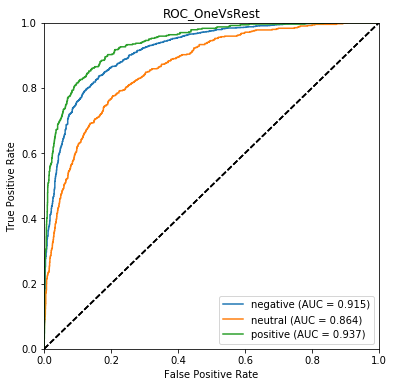

In [103]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

### One Vs One with Linear SVM

In [15]:
# One Vs One
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.800887978142


array([[1693,  152,   44],
       [ 186,  344,   50],
       [  86,   65,  308]])

0.890102942598


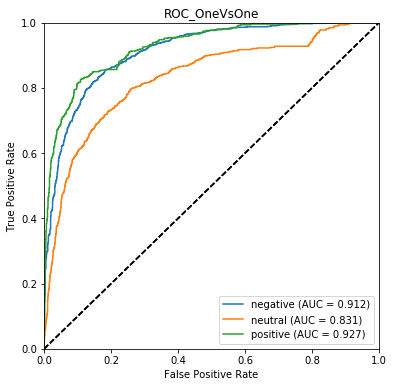

In [16]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

### Gradient Boosting

In [16]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5, n_estimators=500)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.804303278689


array([[1745,   89,   55],
       [ 217,  308,   55],
       [  95,   62,  302]])

0.853717587832


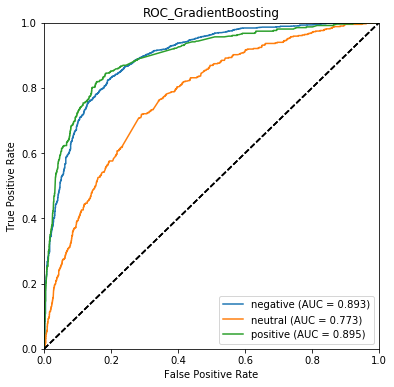

In [17]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [18]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.777663934426


array([[1819,   55,   15],
       [ 315,  234,   31],
       [ 190,   45,  224]])

0.889357698042


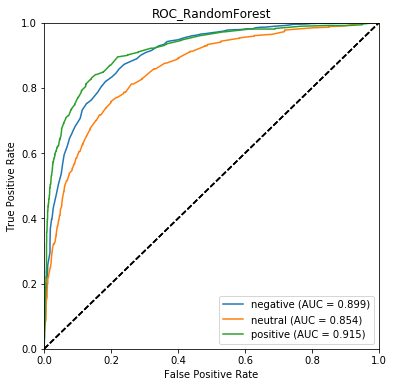

In [19]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [20]:
clf_log=linear_model.LogisticRegression(C=0.35)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.805669398907


array([[1721,  128,   40],
       [ 202,  329,   49],
       [  96,   54,  309]])

0.905526767319


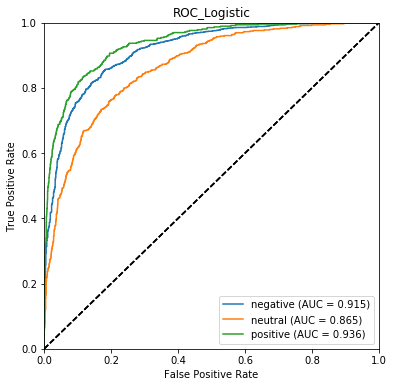

In [21]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

## Tf-Idf

In [22]:
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df=0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [23]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.760587431694


array([[1853,   25,   11],
       [ 390,  170,   20],
       [ 218,   37,  204]])

0.892332474549


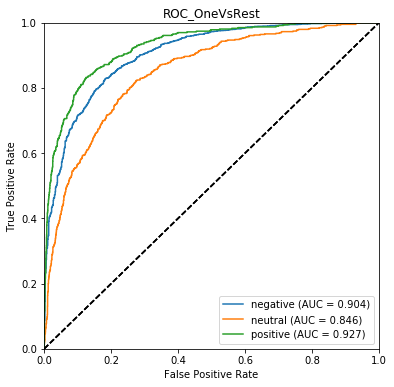

In [24]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [25]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.25))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.811133879781


array([[1756,  100,   33],
       [ 216,  321,   43],
       [ 102,   59,  298]])

0.893672951702


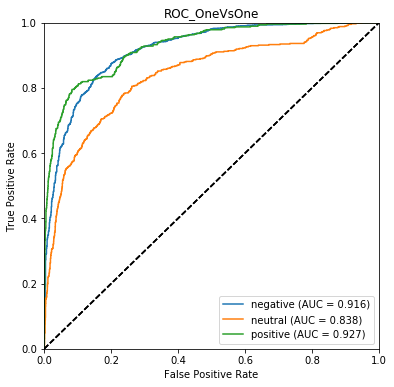

In [26]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [27]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.780737704918


array([[1741,   99,   49],
       [ 271,  269,   40],
       [ 122,   61,  276]])

0.834466530596


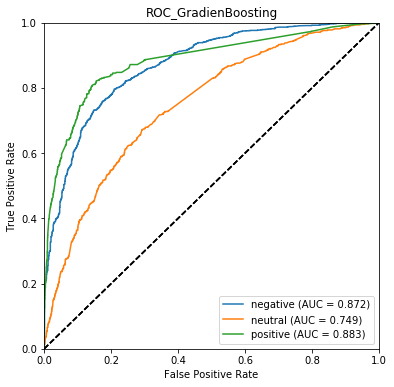

In [28]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [29]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.766393442623


array([[1793,   69,   27],
       [ 315,  229,   36],
       [ 178,   59,  222]])

0.873690374955


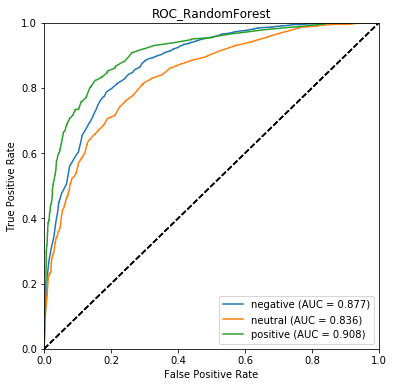

In [30]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [31]:
clf_log=linear_model.LogisticRegression(C=3.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.813866120219


array([[1758,   97,   34],
       [ 218,  313,   49],
       [  96,   51,  312]])

0.905743506644


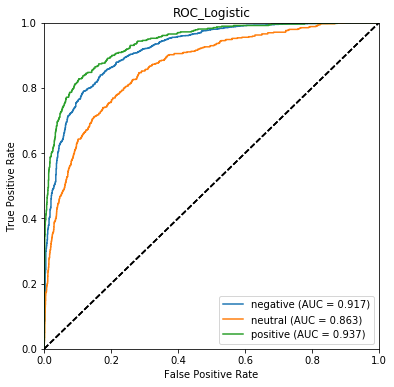

In [32]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

## Bi-grams

In [35]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.811133879781


array([[1726,  122,   41],
       [ 187,  340,   53],
       [  92,   58,  309]])

0.911533619896


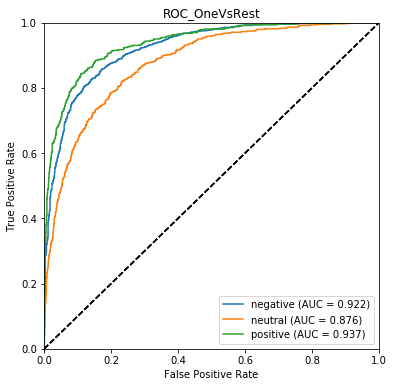

In [37]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [38]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.80737704918


array([[1710,  137,   42],
       [ 178,  354,   48],
       [  90,   69,  300]])

0.897020681132


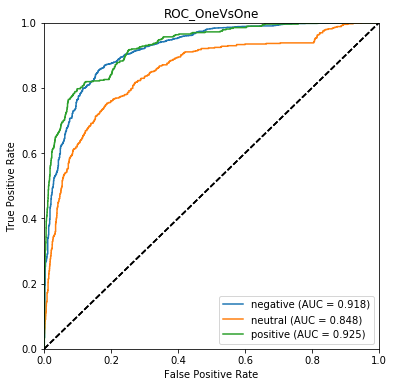

In [39]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [40]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.791325136612


array([[1770,   73,   46],
       [ 268,  263,   49],
       [ 115,   60,  284]])

0.843392802973


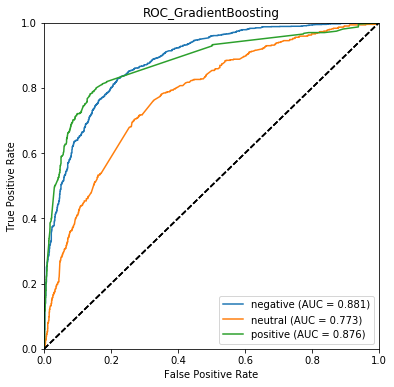

In [41]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [42]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.763319672131


array([[1807,   57,   25],
       [ 338,  215,   27],
       [ 193,   53,  213]])

0.885827935381


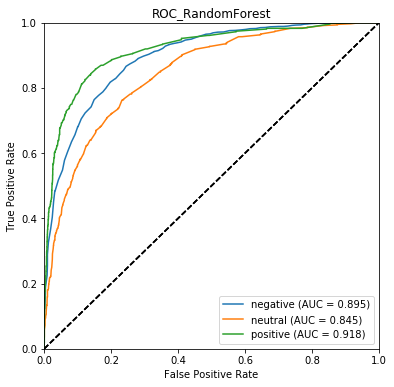

In [43]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [44]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.811133879781


array([[1725,  125,   39],
       [ 182,  344,   54],
       [  93,   60,  306]])

0.911868212037


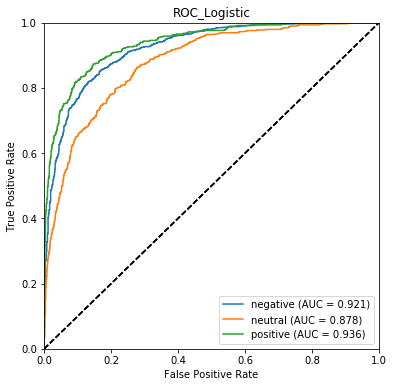

In [45]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Tri-grams

In [46]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.813524590164


array([[1737,  112,   40],
       [ 195,  336,   49],
       [  90,   60,  309]])

0.911028530716


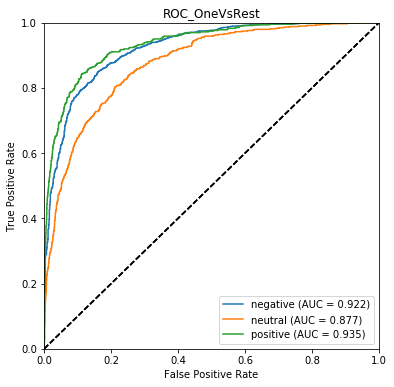

In [48]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [49]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.806693989071


array([[1712,  135,   42],
       [ 181,  352,   47],
       [  93,   68,  298]])

0.896016249774


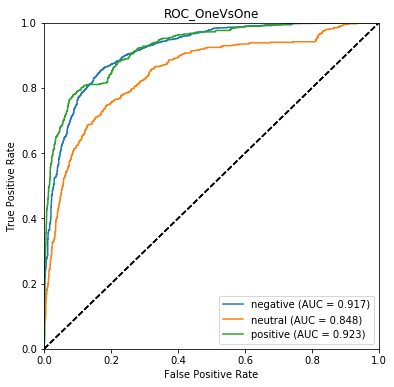

In [50]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [51]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.794398907104


array([[1758,   80,   51],
       [ 267,  272,   41],
       [ 103,   60,  296]])

0.84685327874


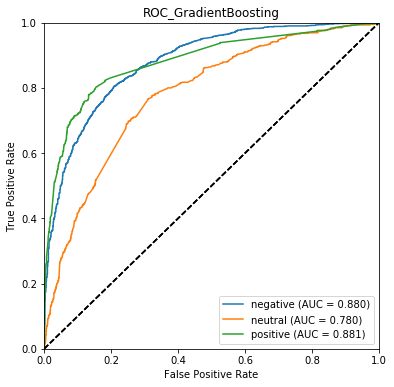

In [52]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [53]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.761270491803


array([[1818,   49,   22],
       [ 355,  201,   24],
       [ 197,   52,  210]])

0.885046986446


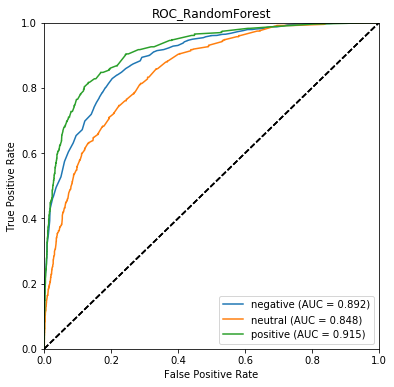

In [54]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [55]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.808743169399


array([[1733,  117,   39],
       [ 195,  336,   49],
       [  99,   61,  299]])

0.911249761076


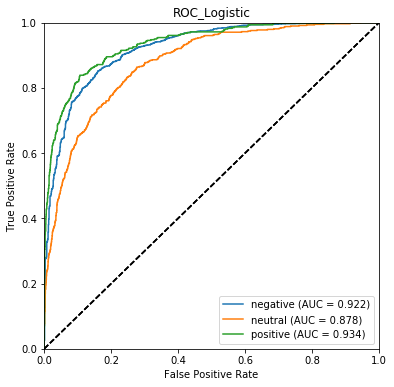

In [56]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Balanced data

In [10]:
data = shuffle(data,random_state=42)

index = list()
pos_count = 0
neg_count = 0 
neu_count = 0

for i in range(data.shape[0]):
    if data.iloc[i]["airline_sentiment"] == "positive":
        if pos_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue 
        pos_count += 1 
    elif data.iloc[i]["airline_sentiment"] == "negative":
        if neg_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neg_count += 1 
    else:
        if neu_count <1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neu_count += 1 
        
balanced_data = data.filter(index,axis = 0)

In [11]:
y_raw = balanced_data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
le.classes_
y = le.transform(y_raw)

In [12]:
tweet = balanced_data['text']

In [13]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.749559082892


array([[303,  66,  32],
       [ 50, 260,  47],
       [ 22,  67, 287]])

0.894249567692


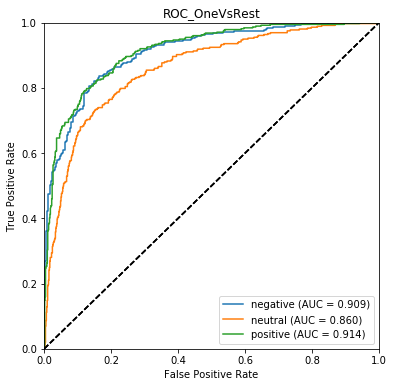

In [15]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [16]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.743386243386


array([[304,  68,  29],
       [ 48, 261,  48],
       [ 24,  74, 278]])

0.885930222444


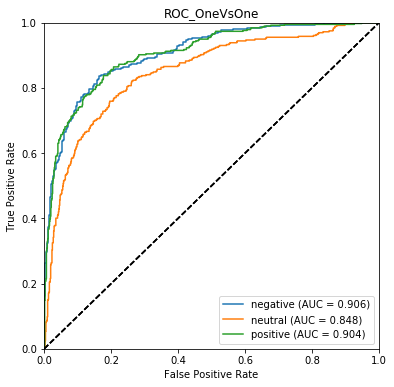

In [17]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [65]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.746913580247


array([[289,  82,  30],
       [ 48, 273,  36],
       [ 21,  70, 285]])

0.844603357633


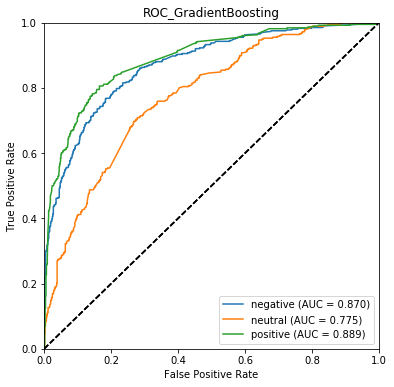

In [66]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [67]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.734567901235


array([[281,  97,  23],
       [ 43, 280,  34],
       [ 29,  75, 272]])

0.887973889014


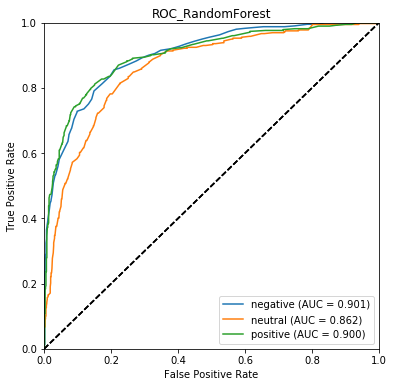

In [68]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [18]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.751322751323


array([[305,  65,  31],
       [ 51, 260,  46],
       [ 25,  64, 287]])

0.894731977958


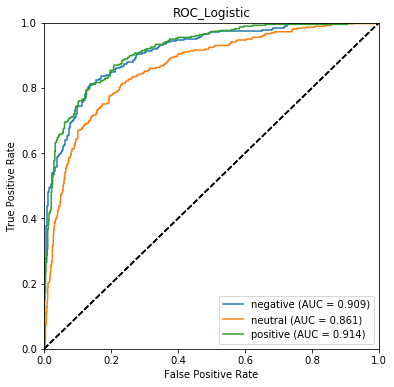

In [19]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [20]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [21]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.750440917108


array([[306,  64,  31],
       [ 53, 262,  42],
       [ 35,  58, 283]])

0.897854435532


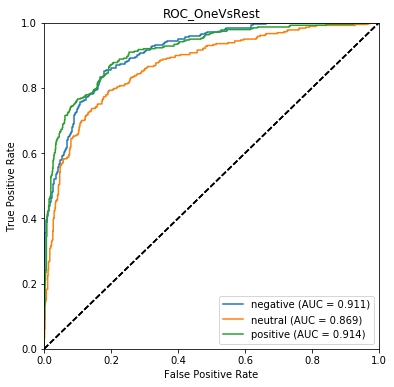

In [22]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [23]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.751322751323


array([[305,  70,  26],
       [ 48, 267,  42],
       [ 36,  60, 280]])

0.889530046105


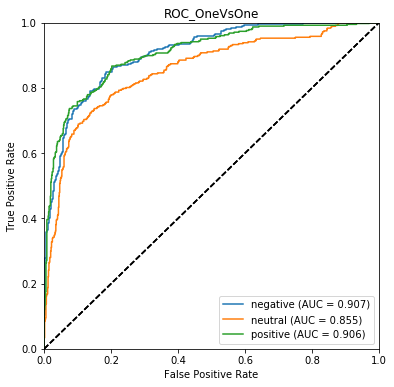

In [24]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [76]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.717813051146


array([[281,  81,  39],
       [ 51, 258,  48],
       [ 35,  66, 275]])

0.839490353222


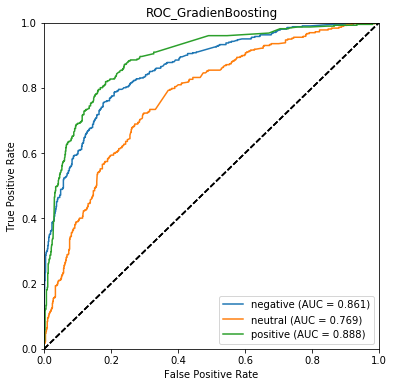

In [77]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [78]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.713403880071


array([[310,  73,  18],
       [ 75, 243,  39],
       [ 45,  75, 256]])

0.873176098499


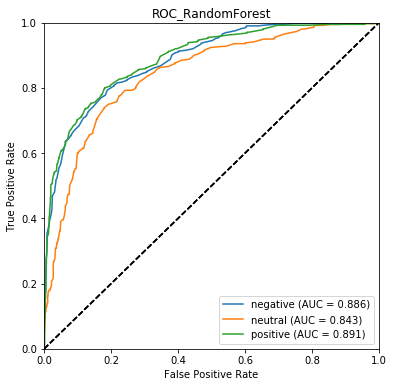

In [79]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [25]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.753968253968


array([[306,  64,  31],
       [ 49, 264,  44],
       [ 34,  57, 285]])

0.897398721969


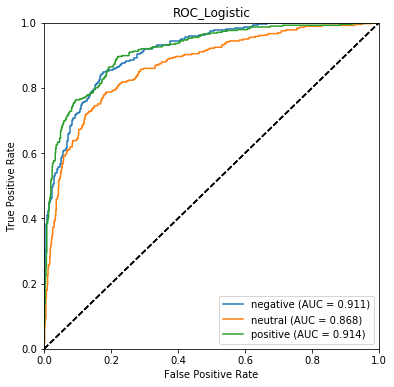

In [26]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [27]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.750440917108


array([[304,  72,  25],
       [ 46, 268,  43],
       [ 25,  72, 279]])

0.9026466763


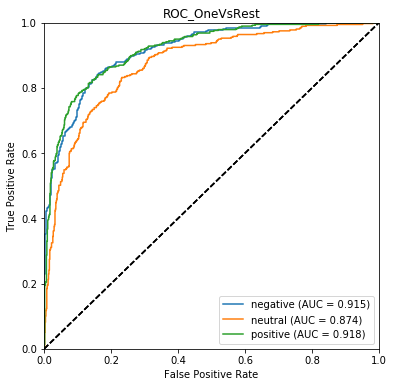

In [29]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [30]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.035))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.756613756614


array([[298,  75,  28],
       [ 42, 280,  35],
       [ 26,  70, 280]])

0.893991759638


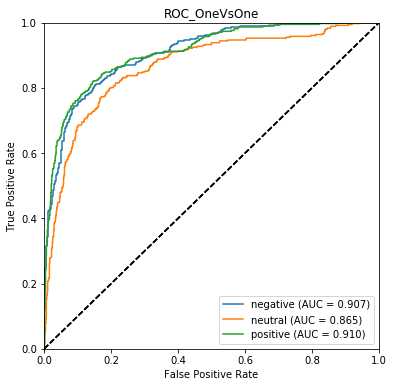

In [31]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [87]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.727513227513


array([[282,  88,  31],
       [ 48, 272,  37],
       [ 28,  77, 271]])

0.842397080834


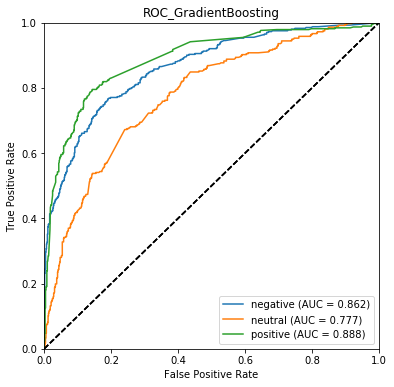

In [88]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [89]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.719576719577


array([[262, 114,  25],
       [ 32, 298,  27],
       [ 30,  90, 256]])

0.88482366707


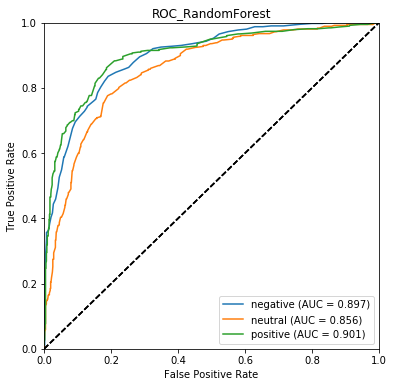

In [90]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [32]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.756613756614


array([[309,  68,  24],
       [ 46, 270,  41],
       [ 26,  71, 279]])

0.902754813385


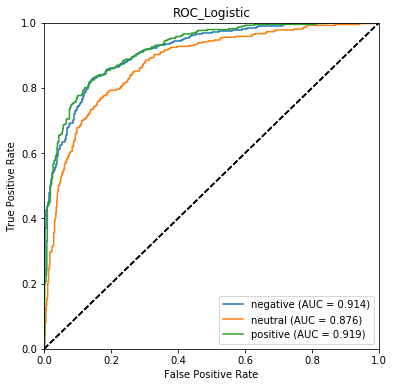

In [33]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [34]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.76102292769


array([[306,  71,  24],
       [ 42, 276,  39],
       [ 25,  70, 281]])

0.901404483006


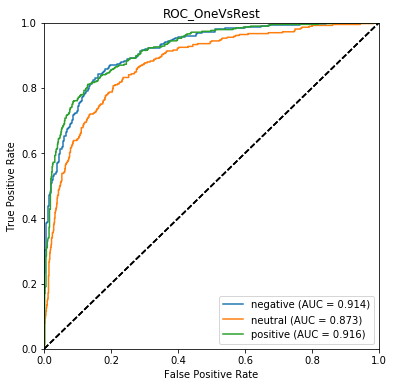

In [36]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [37]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.06))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.754850088183


array([[296,  81,  24],
       [ 40, 279,  38],
       [ 25,  70, 281]])

0.891007243288


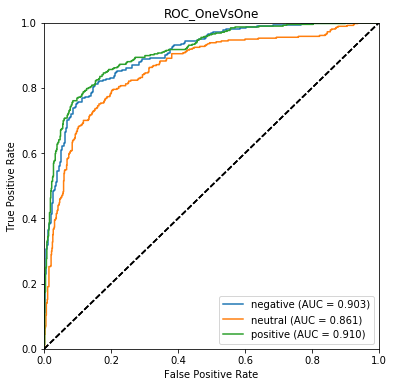

In [38]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [98]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.728395061728


array([[286,  85,  30],
       [ 50, 268,  39],
       [ 25,  79, 272]])

0.84171524873


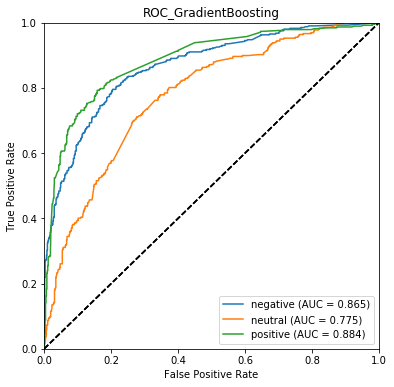

In [99]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [100]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.712522045855


array([[263, 122,  16],
       [ 33, 306,  18],
       [ 27, 110, 239]])

0.884187433579


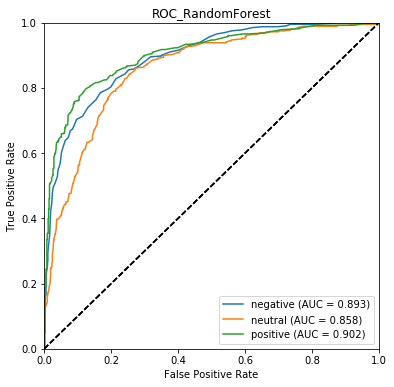

In [101]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [39]:
clf_log=linear_model.LogisticRegression(C=0.85)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.753968253968


array([[306,  69,  26],
       [ 48, 269,  40],
       [ 28,  68, 280]])

0.901173106979


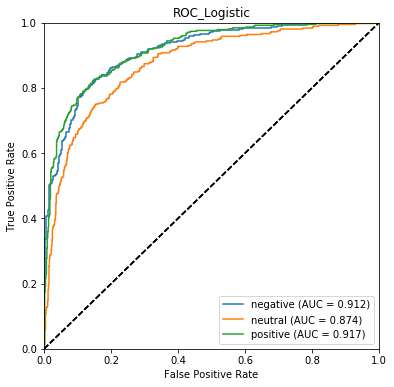

In [40]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Using preprocessed data

In [41]:
# use remove_1
tweet = balanced_data['remove_1']

In [42]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.747795414462


array([[303,  67,  31],
       [ 48, 259,  50],
       [ 23,  67, 286]])

0.893609511419


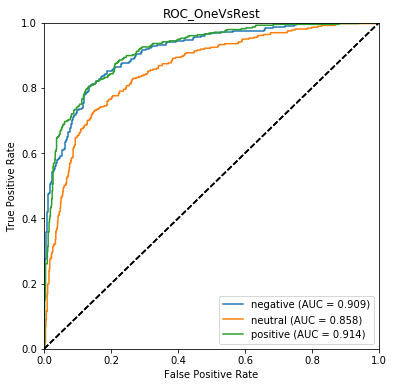

In [44]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [45]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.741622574956


array([[302,  69,  30],
       [ 48, 260,  49],
       [ 24,  73, 279]])

0.885375745165


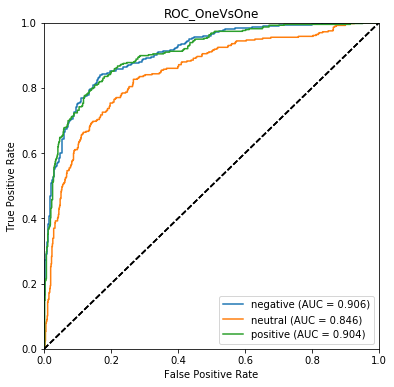

In [46]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [110]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.73897707231


array([[283,  87,  31],
       [ 50, 272,  35],
       [ 28,  65, 283]])

0.843259433574


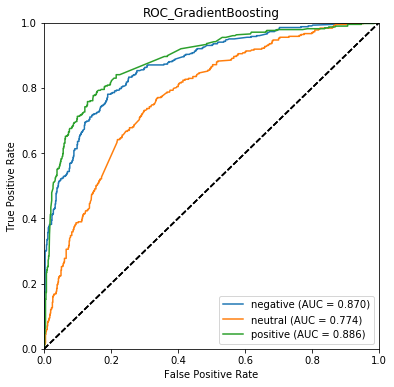

In [111]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [112]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.725749559083


array([[280,  97,  24],
       [ 41, 278,  38],
       [ 32,  79, 265]])

0.887713575702


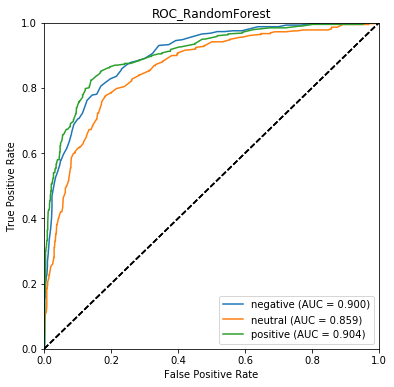

In [113]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [47]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.750440917108


array([[305,  66,  30],
       [ 51, 259,  47],
       [ 24,  65, 287]])

0.893937195079


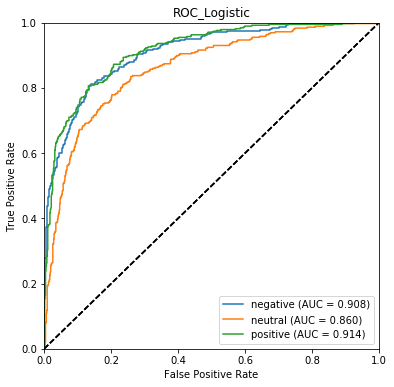

In [48]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [49]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [50]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.746031746032


array([[306,  66,  29],
       [ 54, 258,  45],
       [ 36,  58, 282]])

0.896250603101


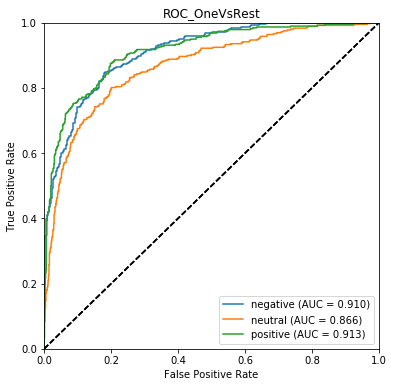

In [51]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [52]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.747795414462


array([[304,  72,  25],
       [ 48, 264,  45],
       [ 34,  62, 280]])

0.888194209628


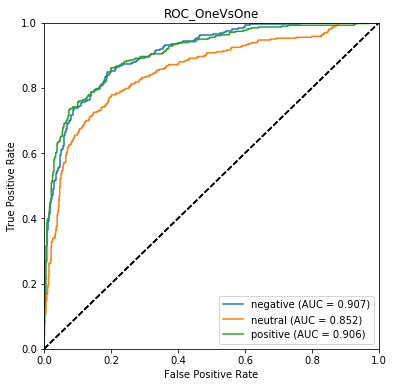

In [53]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [121]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.716931216931


array([[281,  89,  31],
       [ 54, 258,  45],
       [ 31,  71, 274]])

0.835943342334


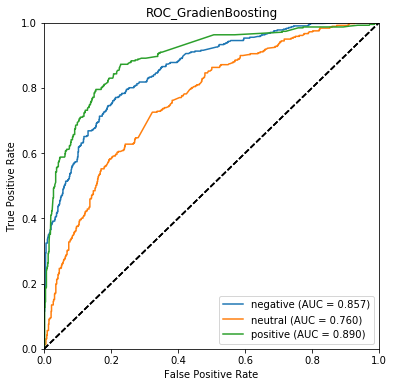

In [122]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [123]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.70811287478


array([[304,  77,  20],
       [ 75, 237,  45],
       [ 37,  77, 262]])

0.871260857785


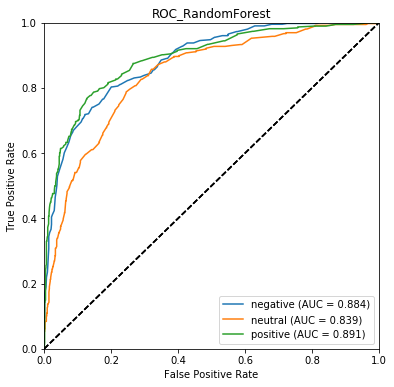

In [124]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [54]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.750440917108


array([[306,  64,  31],
       [ 50, 261,  46],
       [ 35,  57, 284]])

0.896104341485


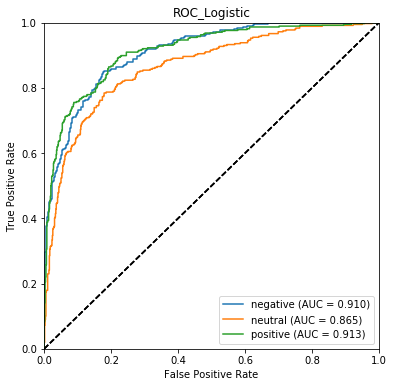

In [55]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [56]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.754850088183


array([[301,  76,  24],
       [ 46, 271,  40],
       [ 25,  67, 284]])

0.901679230156


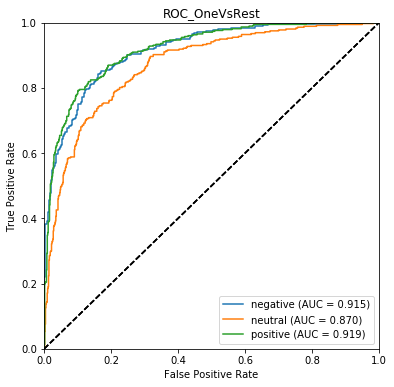

In [58]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [59]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753968253968


array([[300,  77,  24],
       [ 43, 275,  39],
       [ 27,  69, 280]])

0.892665099521


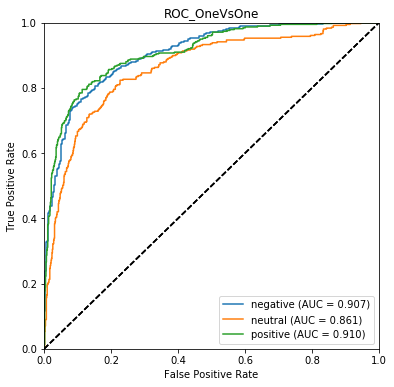

In [60]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [132]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.726631393298


array([[277,  92,  32],
       [ 48, 270,  39],
       [ 24,  75, 277]])

0.843596816421


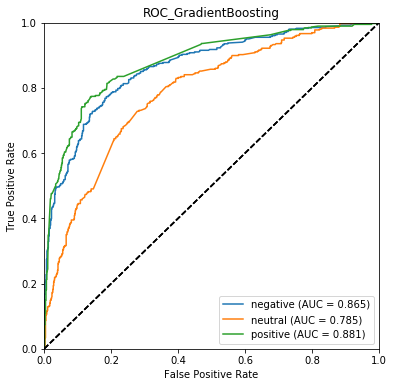

In [133]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [134]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.70811287478


array([[253, 125,  23],
       [ 30, 299,  28],
       [ 25, 100, 251]])

0.886044717648


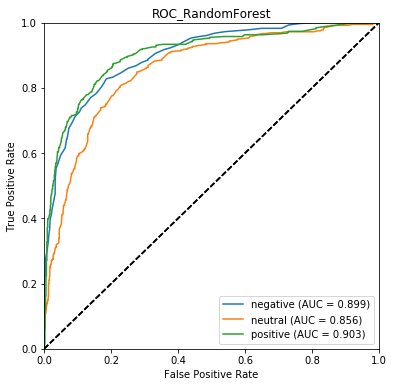

In [135]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [61]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.758377425044


array([[309,  69,  23],
       [ 47, 268,  42],
       [ 27,  66, 283]])

0.90200859084


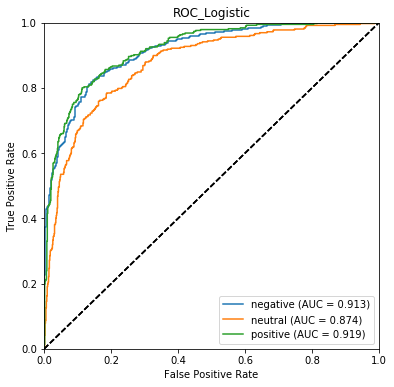

In [62]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [63]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.755731922399


array([[302,  76,  23],
       [ 45, 270,  42],
       [ 25,  66, 285]])

0.900413289439


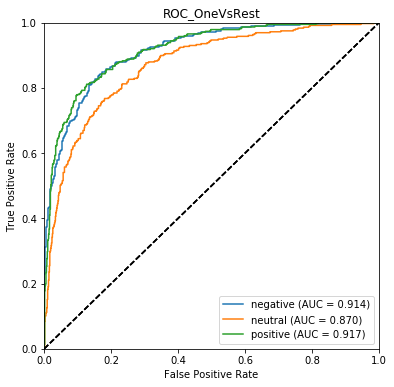

In [65]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [66]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753968253968


array([[297,  81,  23],
       [ 40, 279,  38],
       [ 25,  72, 279]])

0.890017634334


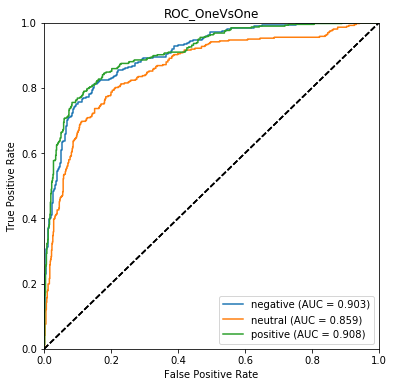

In [67]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [143]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.730158730159


array([[278,  87,  36],
       [ 43, 278,  36],
       [ 27,  77, 272]])

0.839680241002


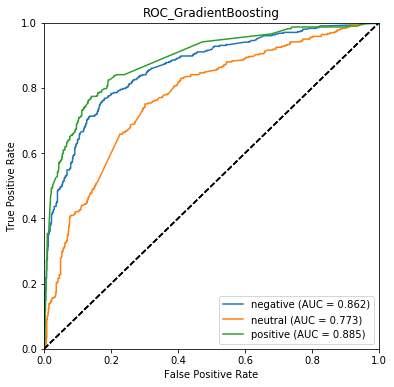

In [144]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [145]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.70987654321


array([[262, 118,  21],
       [ 34, 297,  26],
       [ 28, 102, 246]])

0.880391220245


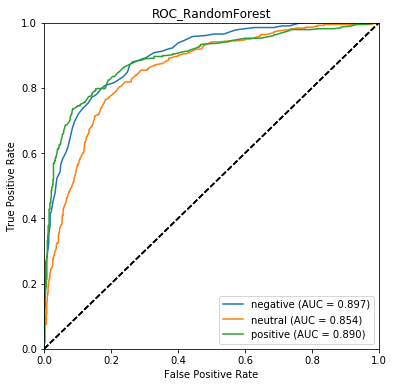

In [146]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [68]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.756613756614


array([[308,  70,  23],
       [ 47, 268,  42],
       [ 26,  68, 282]])

0.900294111801


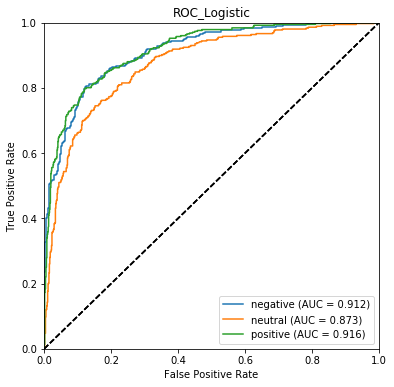

In [69]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [70]:
# use remove_2
tweet = balanced_data['remove_2']

In [71]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.748677248677


array([[295,  73,  33],
       [ 44, 266,  47],
       [ 30,  58, 288]])

0.891936656671


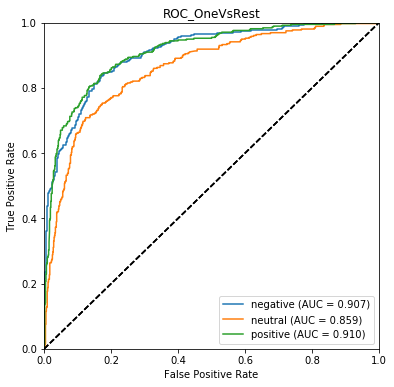

In [73]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [74]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.739858906526


array([[289,  83,  29],
       [ 45, 269,  43],
       [ 29,  66, 281]])

0.882534250092


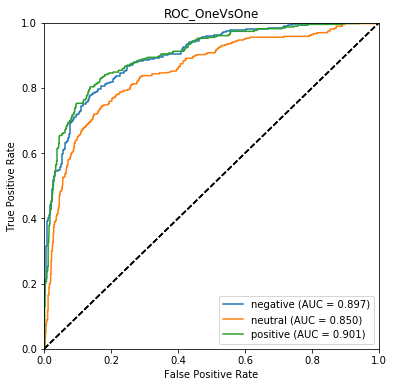

In [75]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.73721340388
0.841528199069
0.723985890653
0.884823744148


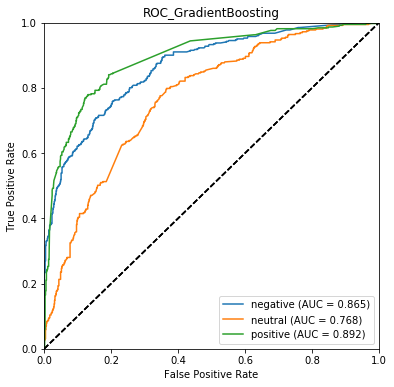

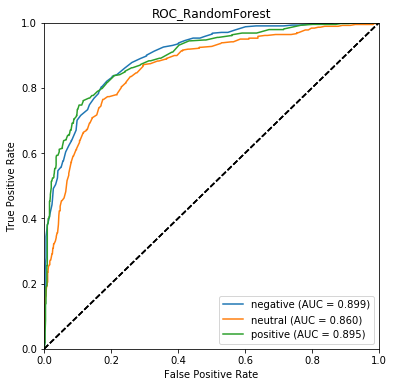

In [155]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [76]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.750440917108


array([[295,  74,  32],
       [ 44, 268,  45],
       [ 32,  56, 288]])

0.892354364488


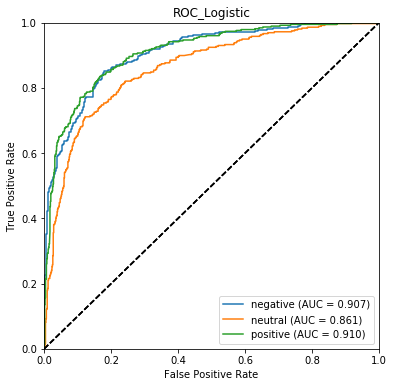

In [77]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [78]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [79]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.746031746032


array([[301,  69,  31],
       [ 53, 262,  42],
       [ 39,  54, 283]])

0.892364028095


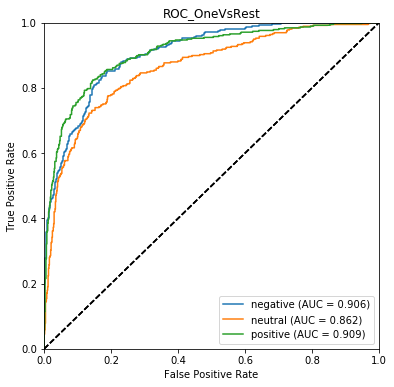

In [80]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [81]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.73721340388


array([[300,  70,  31],
       [ 51, 263,  43],
       [ 44,  59, 273]])

0.881760831314


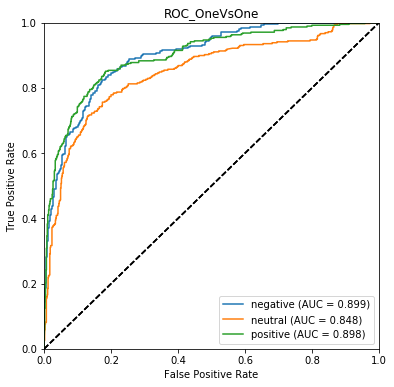

In [82]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

0.716931216931
0.841233902422
0.708994708995
0.876948571695


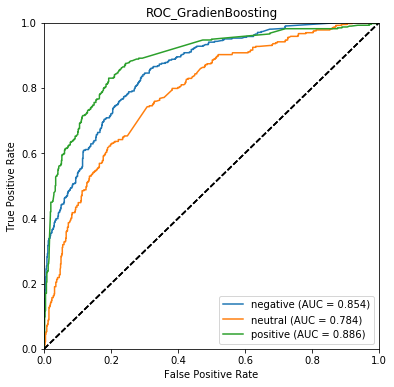

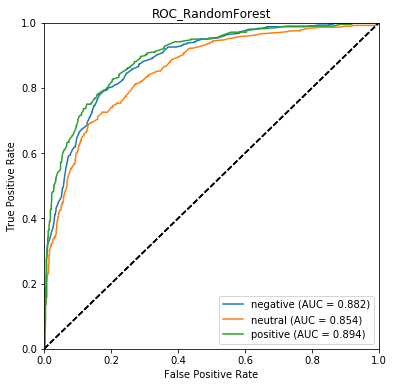

In [163]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [83]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.746913580247


array([[301,  69,  31],
       [ 50, 261,  46],
       [ 39,  52, 285]])

0.892416309691


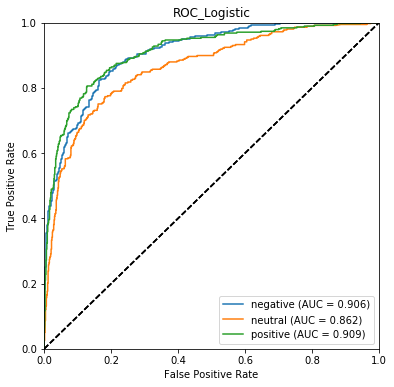

In [84]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [85]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.744268077601


array([[289,  80,  32],
       [ 42, 270,  45],
       [ 31,  60, 285]])

0.899877022645


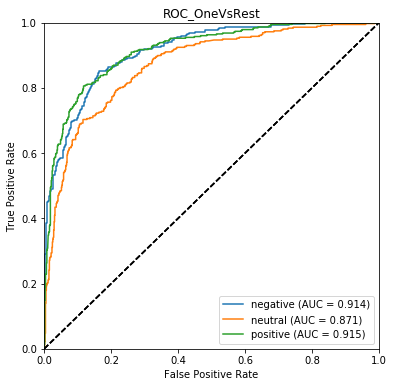

In [87]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [88]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.734567901235


array([[285,  86,  30],
       [ 41, 274,  42],
       [ 31,  71, 274]])

0.889245181912


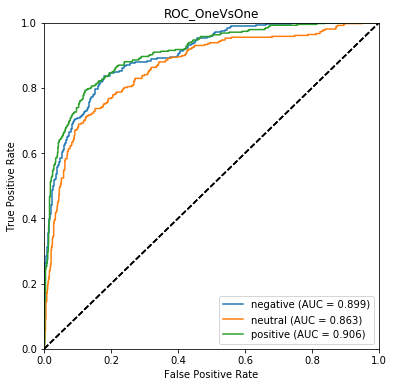

In [89]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.722222222222
0.835131583526
0.70987654321
0.881514603074


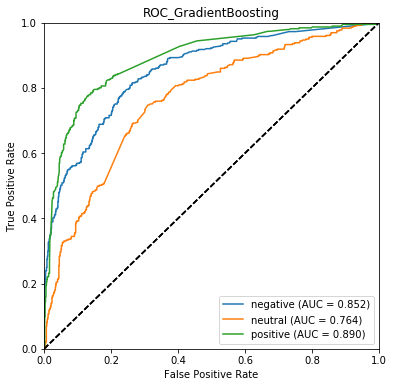

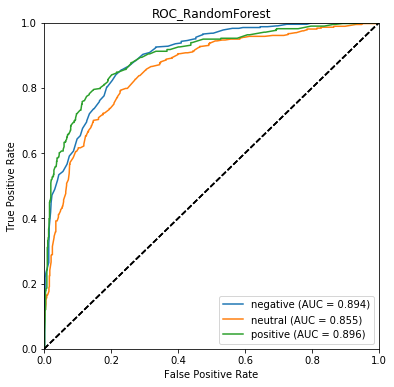

In [171]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [172]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.747795414462


array([[293,  77,  31],
       [ 42, 270,  45],
       [ 33,  58, 285]])

0.899266684869


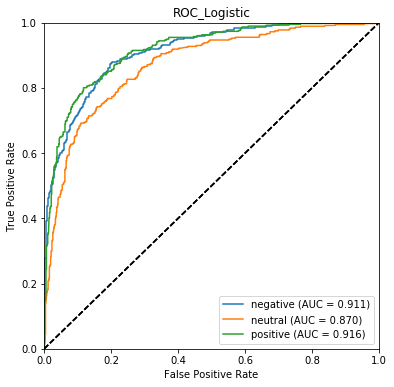

In [90]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [92]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.741622574956


array([[286,  84,  31],
       [ 41, 273,  43],
       [ 30,  64, 282]])

0.898704754779


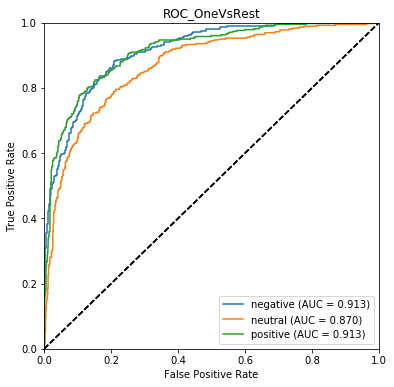

In [94]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [95]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.727513227513


array([[284,  87,  30],
       [ 42, 273,  42],
       [ 36,  72, 268]])

0.887079543222


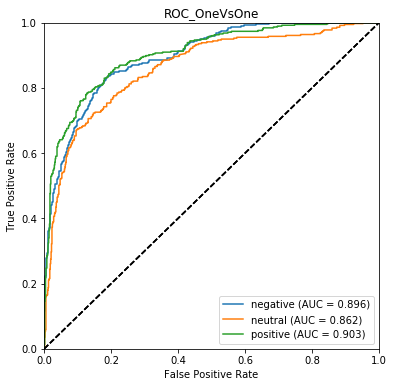

In [96]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.729276895944
0.83889567865
0.704585537919
0.885175440757


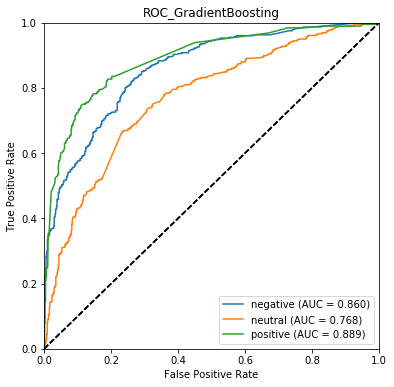

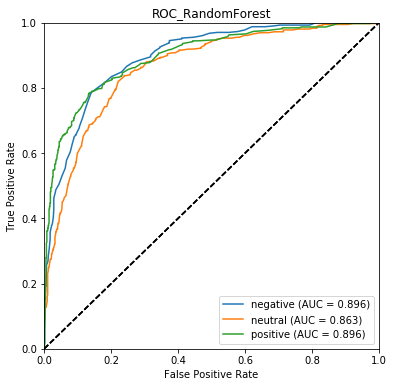

In [97]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [98]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.746031746032


array([[294,  76,  31],
       [ 42, 270,  45],
       [ 34,  60, 282]])

0.899173777275


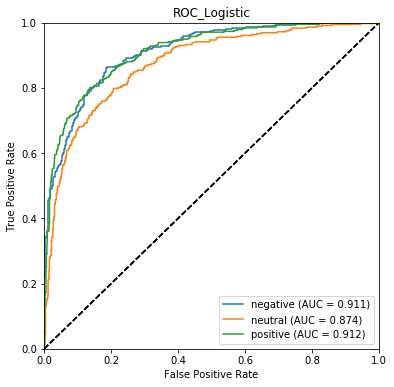

In [99]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [181]:
# use remove_3
tweet = balanced_data['remove_3']

In [182]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.748677248677


array([[303,  67,  31],
       [ 49, 259,  49],
       [ 23,  66, 287]])

0.893633833313


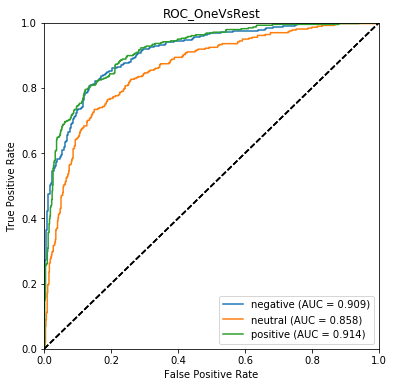

In [184]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [185]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.741622574956


array([[302,  69,  30],
       [ 48, 260,  49],
       [ 24,  73, 279]])

0.885155333675


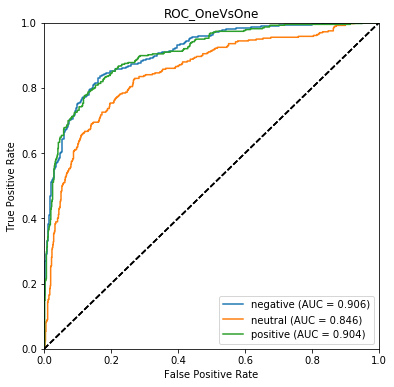

In [186]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.73897707231
0.844600742711
0.73544973545
0.884981390473


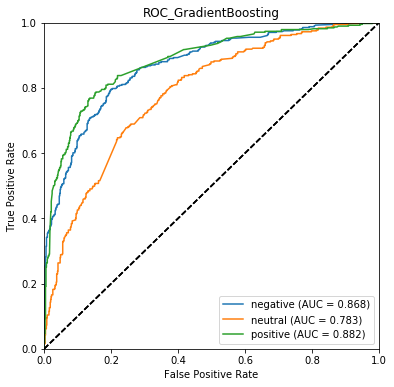

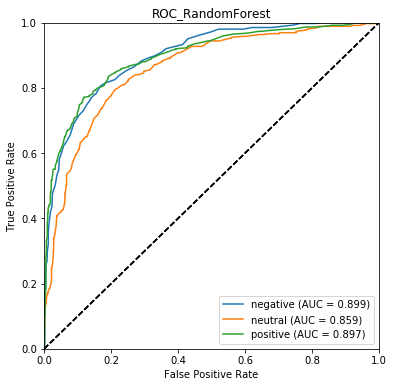

In [187]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [188]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.748677248677


array([[304,  67,  30],
       [ 51, 259,  47],
       [ 26,  64, 286]])

0.893834061379


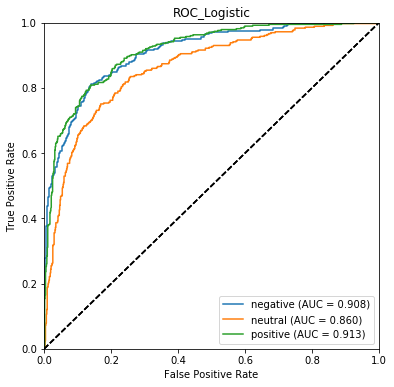

In [189]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [190]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [191]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.748677248677


array([[306,  66,  29],
       [ 52, 262,  43],
       [ 35,  60, 281]])

0.896031035591


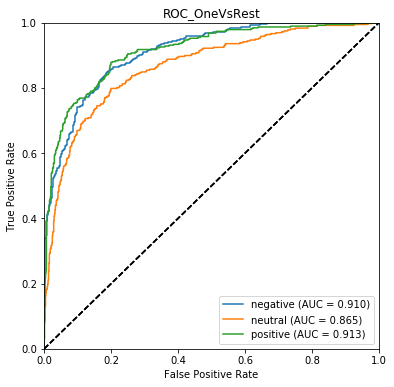

In [192]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [193]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.744268077601


array([[302,  73,  26],
       [ 49, 263,  45],
       [ 34,  63, 279]])

0.887491342182


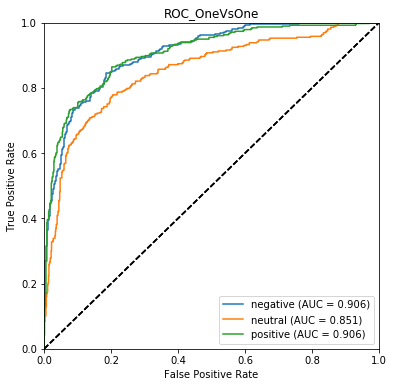

In [194]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

0.714285714286
0.834389901747
0.71164021164
0.87722166567


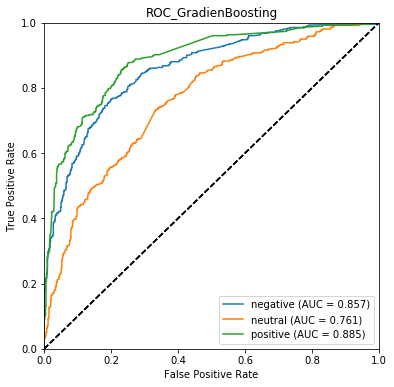

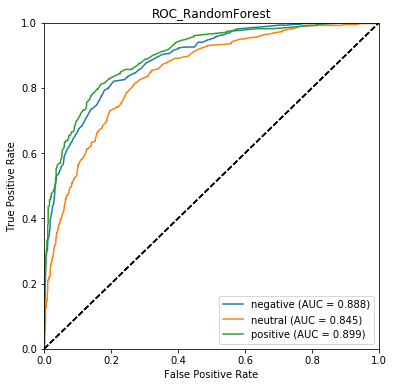

In [195]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [196]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.752204585538


array([[306,  64,  31],
       [ 49, 262,  46],
       [ 32,  59, 285]])

0.895827429692


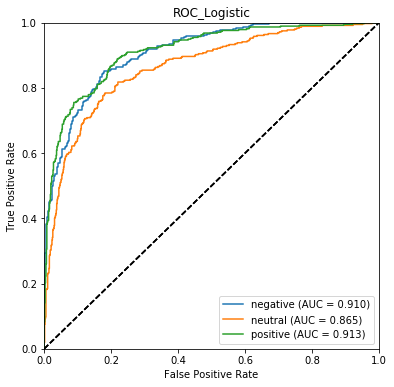

In [197]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [198]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.754850088183


array([[301,  76,  24],
       [ 46, 271,  40],
       [ 25,  67, 284]])

0.901605295442


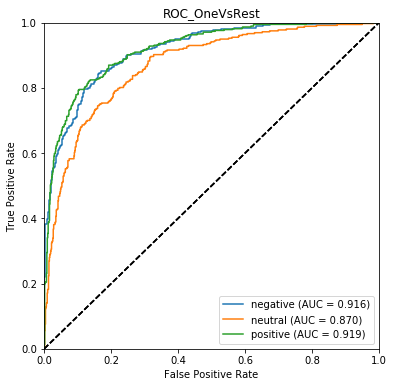

In [200]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [201]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.754850088183


array([[300,  76,  25],
       [ 43, 276,  38],
       [ 27,  69, 280]])

0.89266302239


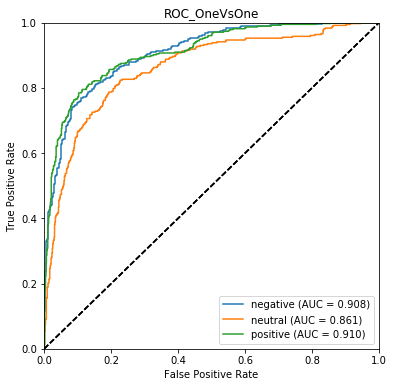

In [202]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.736331569665
0.847423014102
0.713403880071
0.885701625636


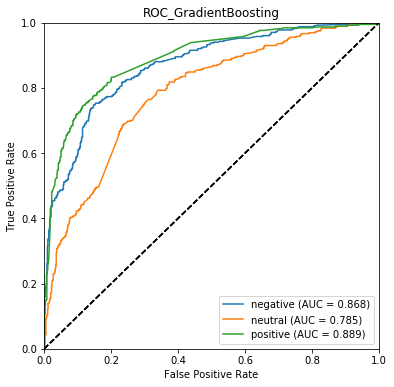

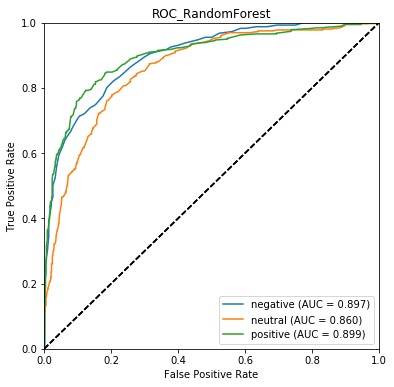

In [203]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [204]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.759259259259


array([[309,  69,  23],
       [ 46, 270,  41],
       [ 27,  67, 282]])

0.901950221685


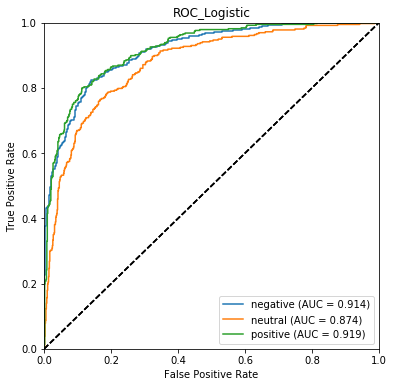

In [205]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [206]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.755731922399


array([[303,  75,  23],
       [ 45, 270,  42],
       [ 26,  66, 284]])

0.900402080714


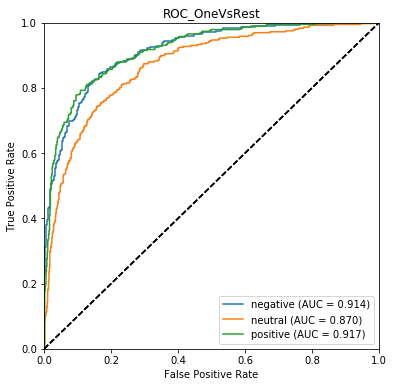

In [208]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [209]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753086419753


array([[296,  81,  24],
       [ 40, 279,  38],
       [ 25,  72, 279]])

0.889867028204


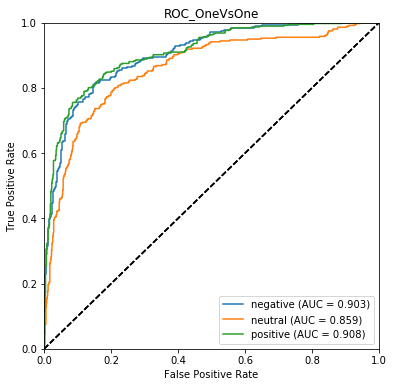

In [210]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.718694885362
0.838245791427
0.703703703704
0.882821336081


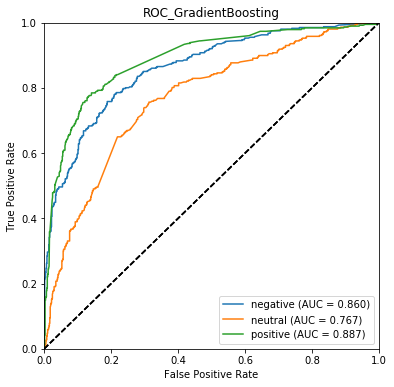

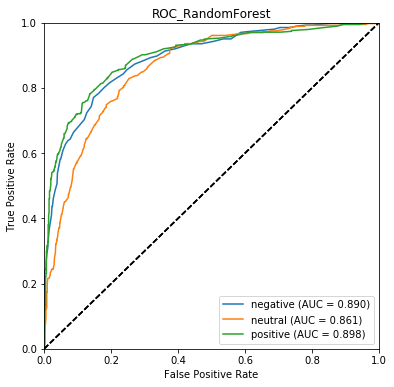

In [211]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [212]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.757495590829


array([[309,  69,  23],
       [ 47, 268,  42],
       [ 26,  68, 282]])

0.900232067171


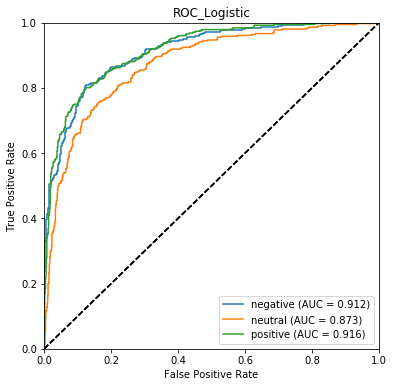

In [213]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [214]:
# use remove_5
tweet = balanced_data['remove_5']

In [215]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.748677248677


array([[303,  67,  31],
       [ 50, 259,  48],
       [ 25,  64, 287]])

0.895791221249


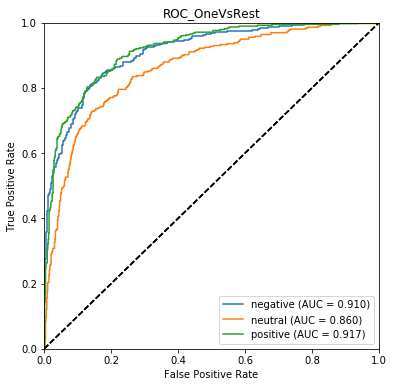

In [217]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [218]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.745149911817


array([[304,  68,  29],
       [ 48, 261,  48],
       [ 26,  70, 280]])

0.887597238374


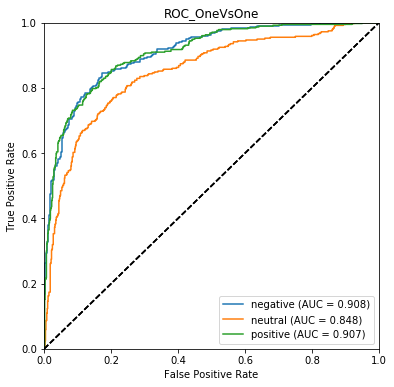

In [219]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [220]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.747795414462


array([[287,  80,  34],
       [ 48, 271,  38],
       [ 25,  61, 290]])

0.846470697337


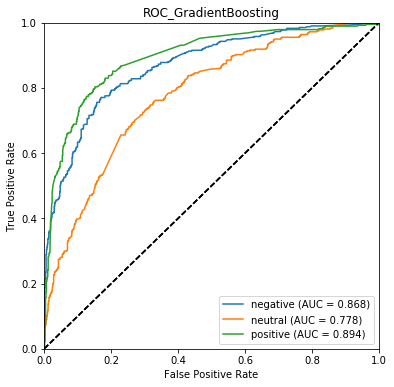

In [221]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [222]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.739858906526


array([[288,  83,  30],
       [ 43, 279,  35],
       [ 32,  72, 272]])

0.888054344382


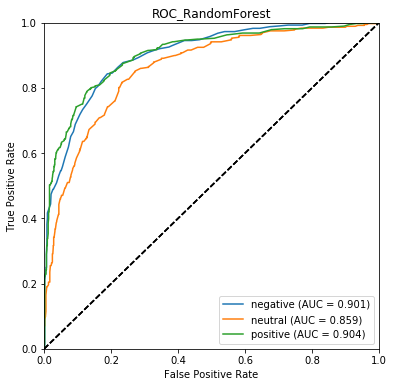

In [223]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [224]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.750440917108


array([[305,  65,  31],
       [ 49, 260,  48],
       [ 26,  64, 286]])

0.896109728232


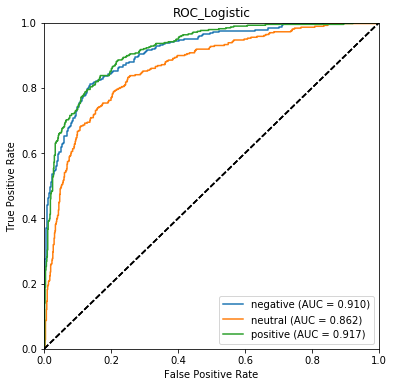

In [225]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [226]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [227]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.755731922399


array([[306,  66,  29],
       [ 52, 263,  42],
       [ 36,  52, 288]])

0.898871745408


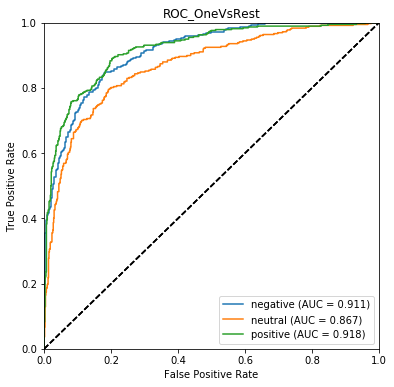

In [228]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [229]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.747795414462


array([[302,  74,  25],
       [ 47, 267,  43],
       [ 36,  61, 279]])

0.889348385479


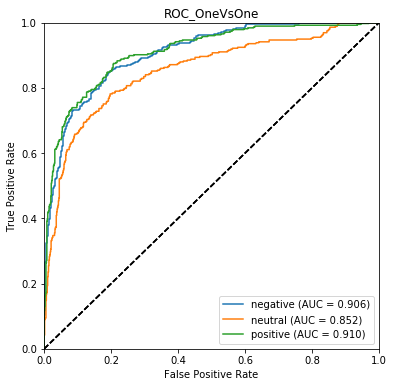

In [230]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [231]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.728395061728


array([[288,  81,  32],
       [ 46, 264,  47],
       [ 32,  70, 274]])

0.839595654843


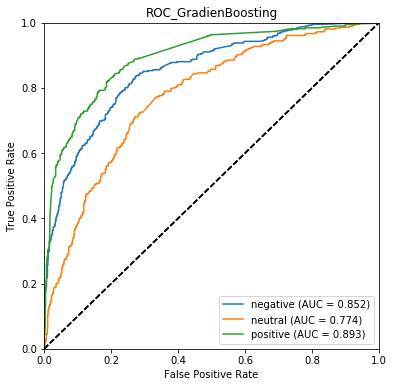

In [232]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [233]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.716049382716


array([[302,  76,  23],
       [ 69, 248,  40],
       [ 42,  72, 262]])

0.873866497145


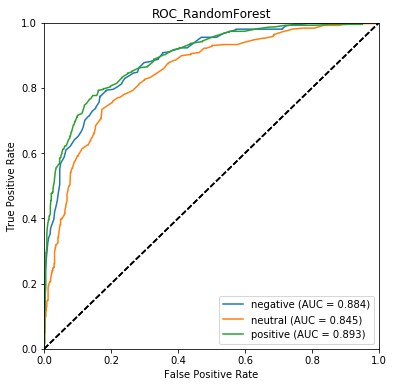

In [234]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [235]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.747795414462


array([[303,  67,  31],
       [ 51, 261,  45],
       [ 37,  55, 284]])

0.898627952308


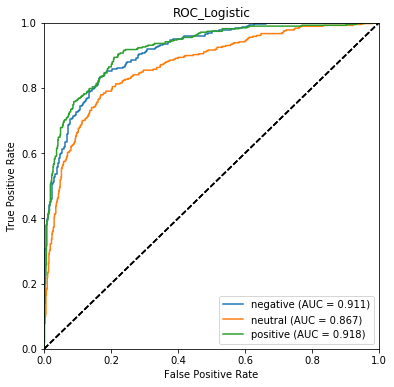

In [236]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [237]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.756613756614


array([[301,  75,  25],
       [ 45, 272,  40],
       [ 26,  65, 285]])

0.903184120326


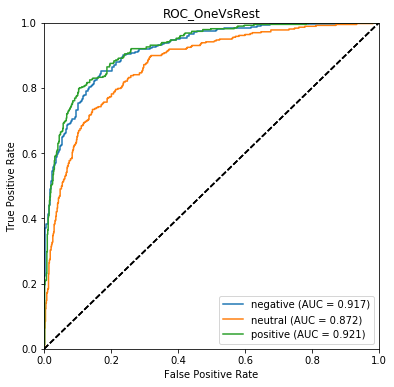

In [239]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [240]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753086419753


array([[299,  77,  25],
       [ 43, 275,  39],
       [ 27,  69, 280]])

0.894240492741


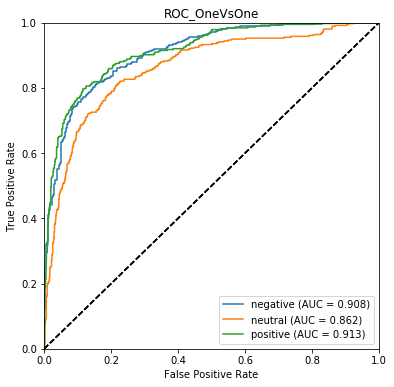

In [241]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.73897707231
0.845853355478
0.708994708995
0.886953891832


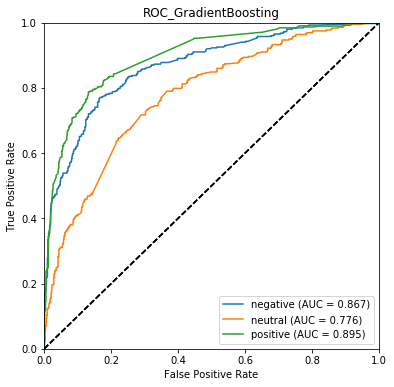

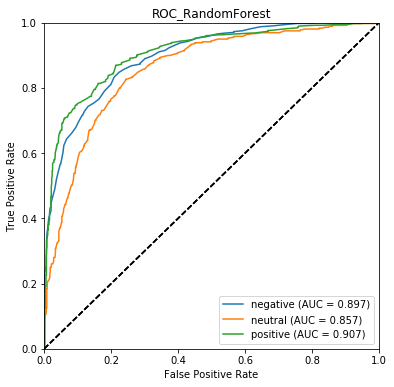

In [242]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [243]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.760141093474


array([[308,  70,  23],
       [ 48, 270,  39],
       [ 26,  66, 284]])

0.903407991713


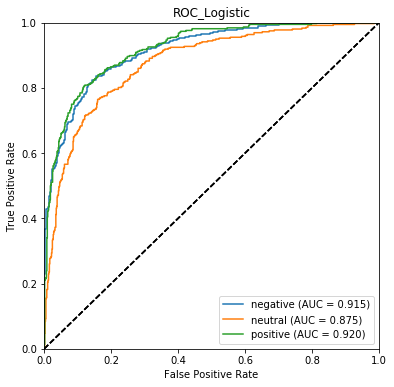

In [244]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [245]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [246]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.756613756614


array([[302,  75,  24],
       [ 45, 271,  41],
       [ 27,  64, 285]])

0.901812244097


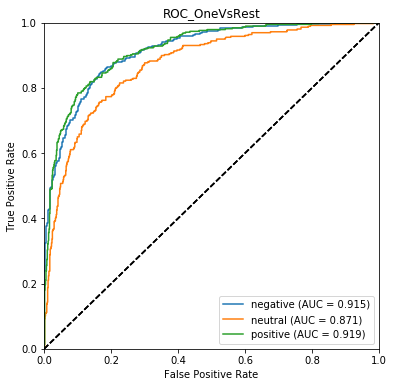

In [247]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [248]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753086419753


array([[295,  82,  24],
       [ 42, 279,  36],
       [ 24,  72, 280]])

0.891112842438


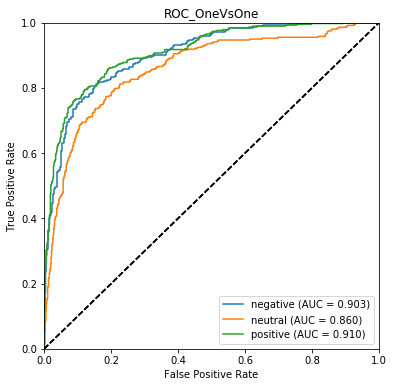

In [249]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.723985890653
0.839932807953
0.713403880071
0.882380614402


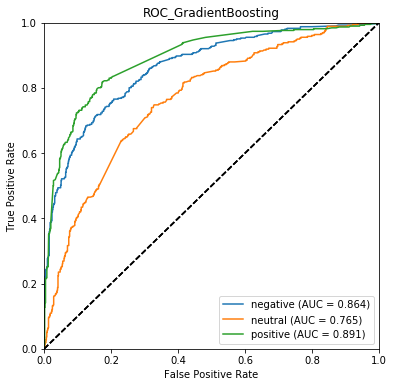

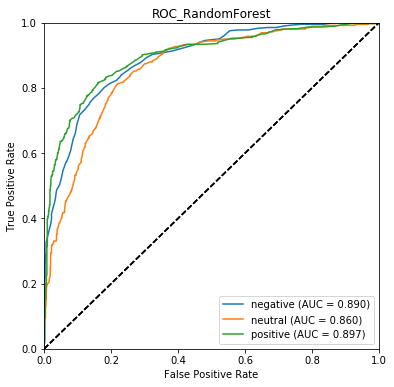

In [250]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [251]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.758377425044


array([[309,  68,  24],
       [ 47, 268,  42],
       [ 27,  66, 283]])

0.901570017143


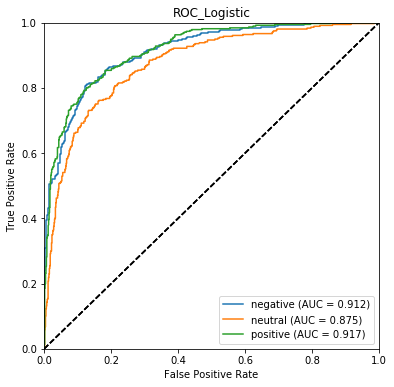

In [252]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [253]:
# use remove_6
tweet = balanced_data['remove_6']

In [254]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.751322751323


array([[305,  67,  29],
       [ 47, 263,  47],
       [ 28,  64, 284]])

0.896309571325


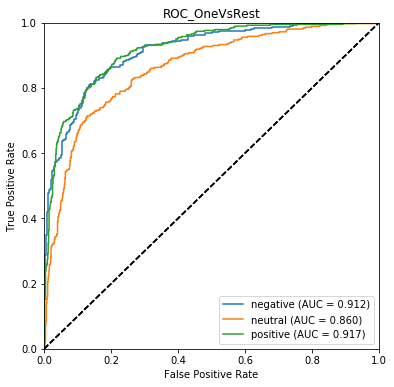

In [256]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [257]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.738095238095


array([[296,  77,  28],
       [ 45, 263,  49],
       [ 27,  71, 278]])

0.887006282066


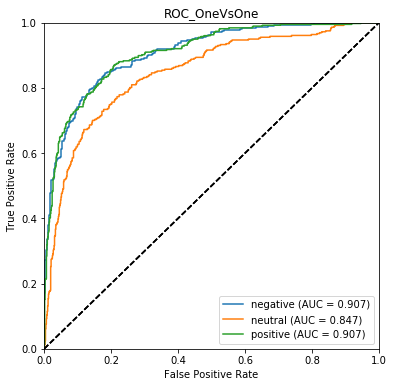

In [258]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.73544973545
0.846031916246
0.724867724868
0.887630596412


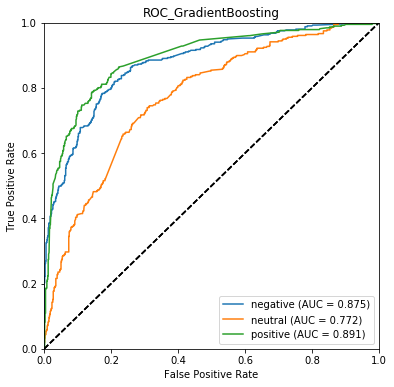

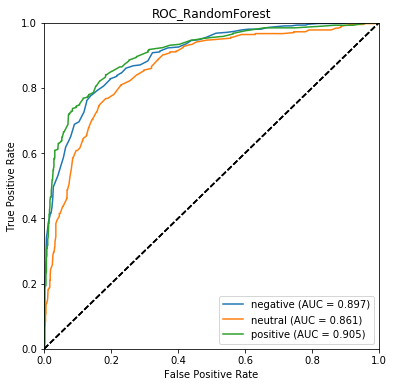

In [259]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [260]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.754850088183


array([[308,  63,  30],
       [ 49, 263,  45],
       [ 30,  61, 285]])

0.896542077513


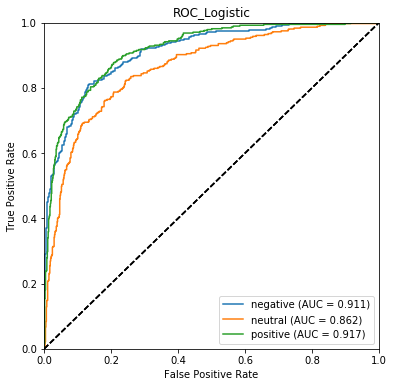

In [261]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [262]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [263]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

0.753968253968


array([[308,  63,  30],
       [ 52, 262,  43],
       [ 36,  55, 285]])

0.89905926237


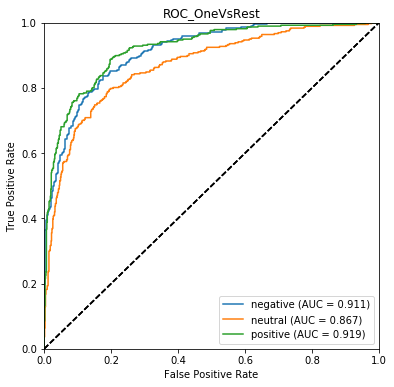

In [264]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [265]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.752204585538


array([[306,  69,  26],
       [ 46, 268,  43],
       [ 36,  61, 279]])

0.889135490867


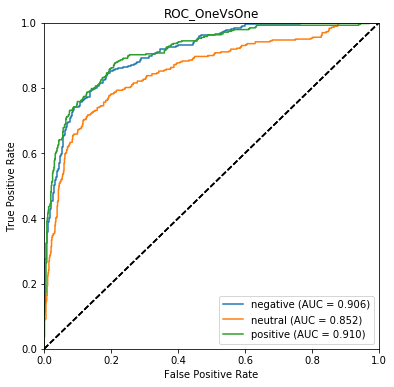

In [266]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

0.719576719577
0.842435981725
0.719576719577
0.873325095109


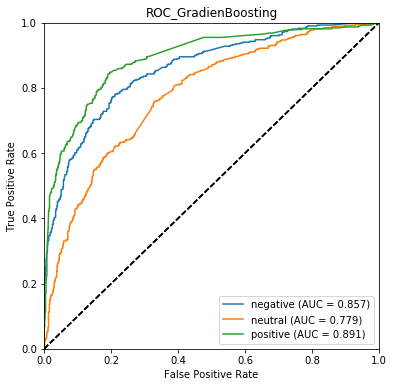

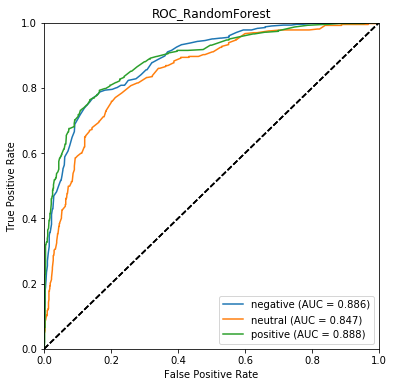

In [267]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [268]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.750440917108


array([[306,  67,  28],
       [ 49, 261,  47],
       [ 36,  56, 284]])

0.898945076847


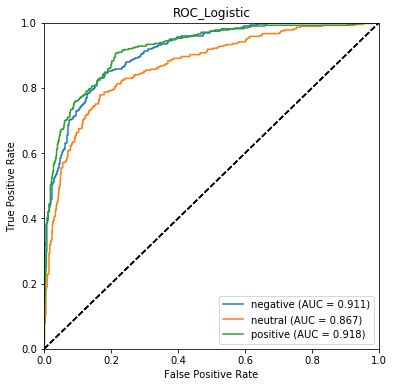

In [269]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [270]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [271]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.753968253968


array([[300,  75,  26],
       [ 45, 272,  40],
       [ 25,  68, 283]])

0.903282286935


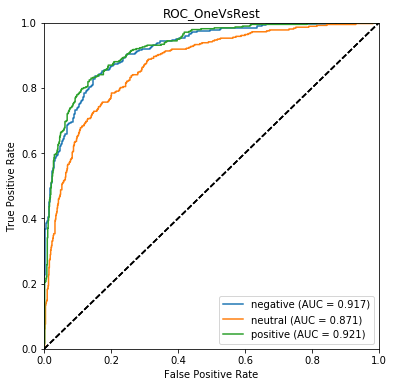

In [272]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [273]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.753086419753


array([[299,  78,  24],
       [ 42, 276,  39],
       [ 27,  70, 279]])

0.894562918762


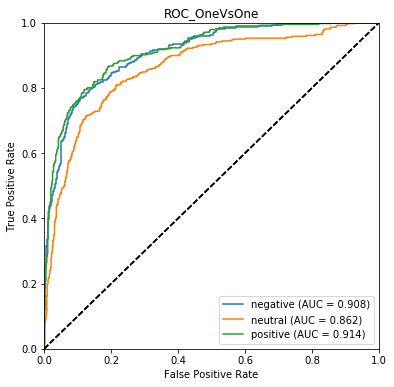

In [274]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.740740740741
0.844976305426
0.724867724868
0.892438367815


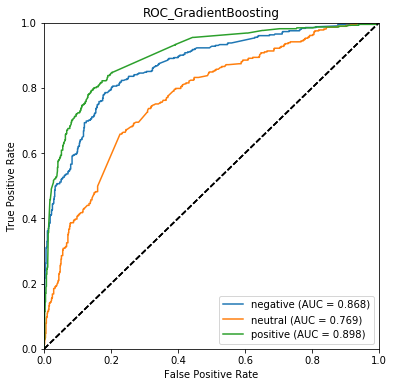

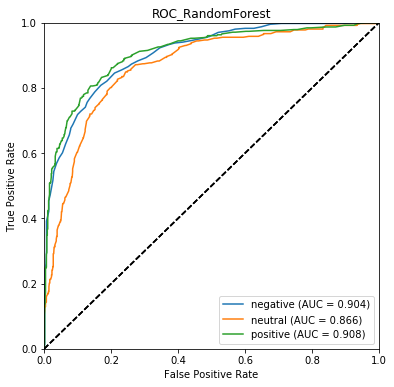

In [275]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [276]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.755731922399


array([[306,  72,  23],
       [ 47, 270,  40],
       [ 27,  68, 281]])

0.903635965445


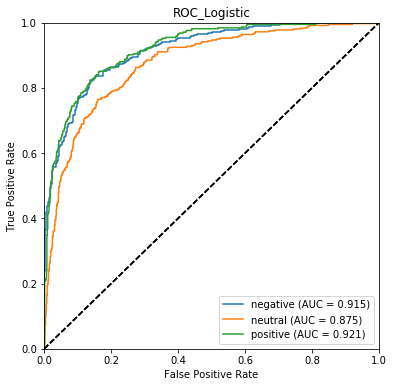

In [277]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [278]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [279]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.753968253968


array([[303,  73,  25],
       [ 45, 272,  40],
       [ 29,  67, 280]])

0.902244114363


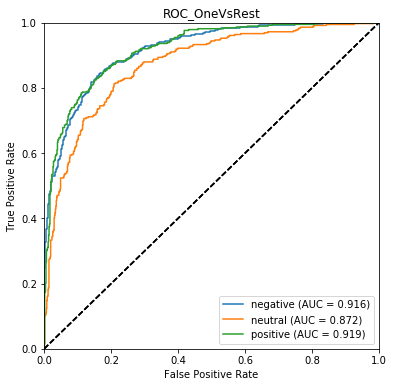

In [280]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [281]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.749559082892


array([[294,  83,  24],
       [ 41, 280,  36],
       [ 25,  75, 276]])

0.891288223168


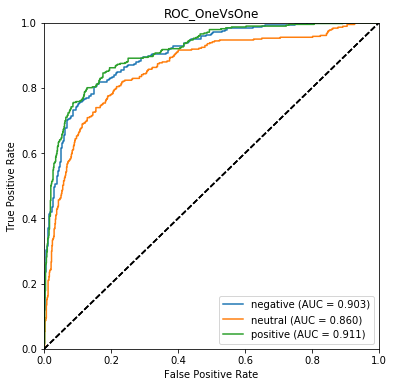

In [282]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

0.723104056437
0.837428284509
0.703703703704
0.886178347524


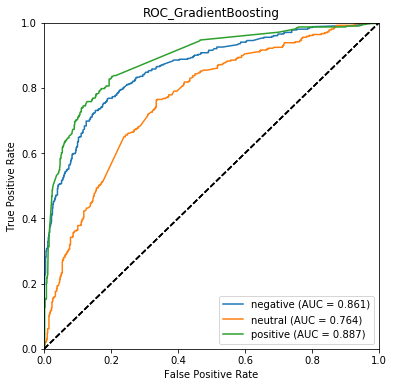

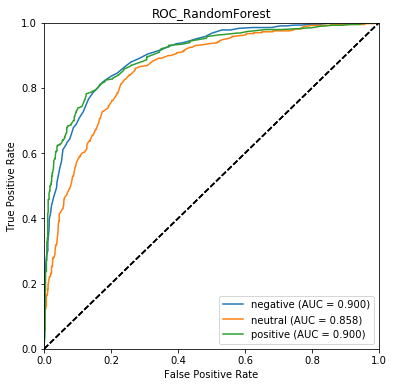

In [283]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [284]:
clf_log=linear_model.LogisticRegression(C=0.7)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.752204585538


array([[306,  72,  23],
       [ 46, 268,  43],
       [ 31,  66, 279]])

0.901633703461


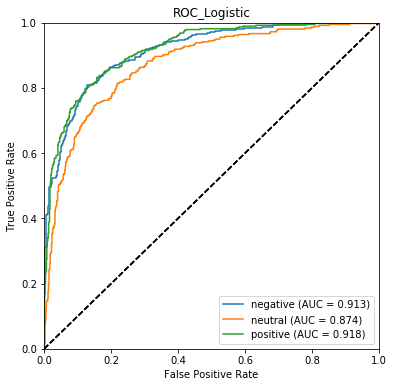

In [285]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [286]:
y_raw = data['airline_sentiment']
y = np.zeros(len(y_raw))
for i in range(len(y_raw)):
    if np.array(y_raw)[i] == 'negative':
        y[i] = 1
    else:
        y[i] = 0

In [287]:
tweet = data['text']

In [288]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
clf_svc = svm.LinearSVC(C=0.05)
clf_svc.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_svc.predict(X_valid))
print(accuracy)

0.858606557377


In [290]:
def plotRocCurve_bi(X_train, y_train, X_valid, y_valid, model, modelname):
    if modelname == 'RandomForest':
        y_score = model.fit(X_train, y_train).predict_proba(X_valid)
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_valid)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_valid, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    fig = plt.figure(figsize = (6, 6))

    # Plot ROC curve
    plt.plot(fpr, tpr, label = ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_' + modelname)
    plt.legend(loc="lower right")

0.927611348168


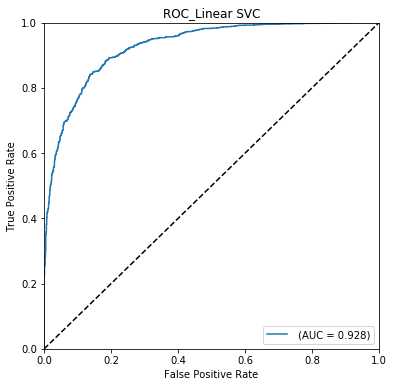

In [291]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_svc, 'Linear SVC')

In [292]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.855191256831


0.929253896227


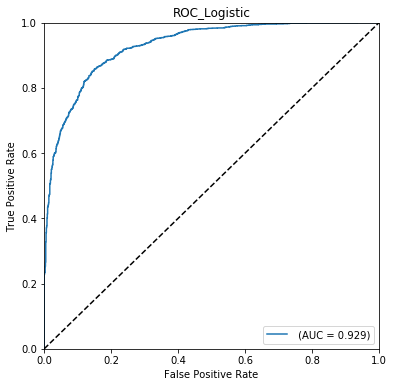

In [293]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [294]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

0.834016393443


0.9005351188


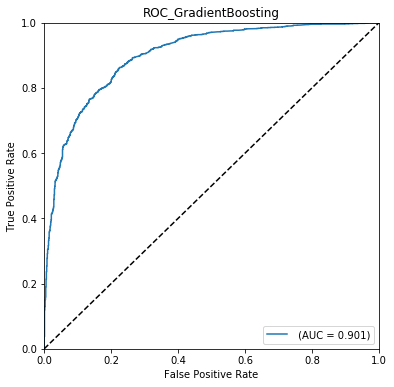

In [295]:
plotRocCurve_bi(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [296]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

0.834016393443


In [297]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [298]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.859289617486


0.927696056932


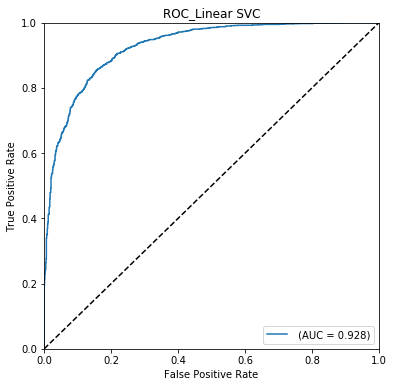

In [299]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [300]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.856215846995


0.928518082815


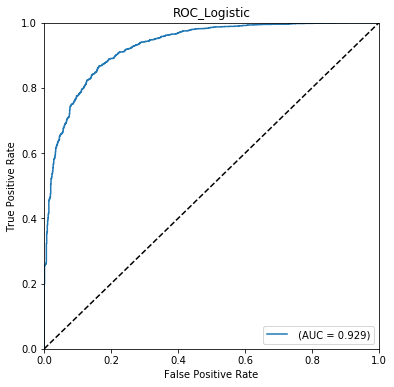

In [301]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [302]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

0.824453551913


0.891627917001


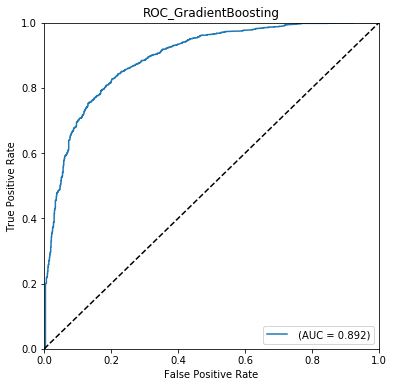

In [303]:
plotRocCurve_bi(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradientBoosting')

In [304]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

0.815573770492


In [305]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

ValueError: bad input shape (2928, 2)

In [306]:
tweet = data['remove_5']

In [307]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
clf_svc = svm.LinearSVC(C=0.03)
clf_svc.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_svc.predict(X_valid))
print(accuracy)

0.856215846995


0.929198008492


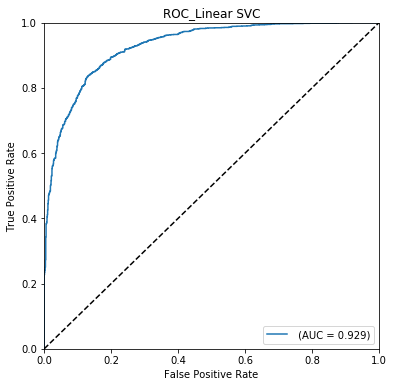

In [309]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_svc, 'Linear SVC')

In [310]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.858948087432


0.929784955022


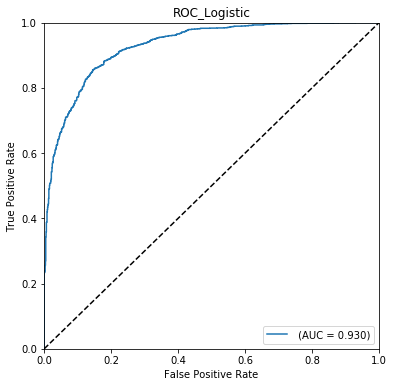

In [311]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [312]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [313]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.857923497268


0.928658428698


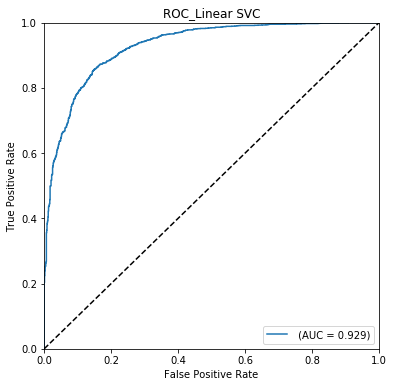

In [314]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [315]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.856898907104


0.929391234698


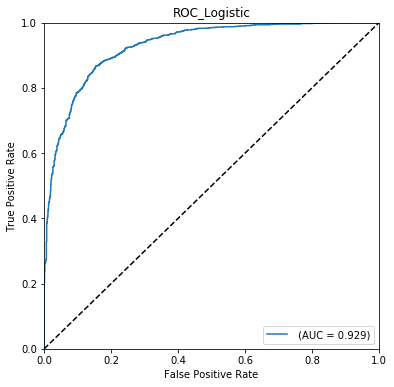

In [316]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [317]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(loss='exponential', learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

0.825819672131


0.898045232475


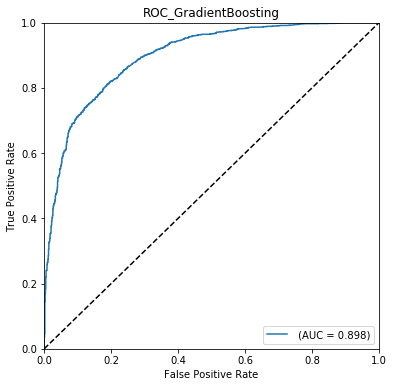

In [318]:
plotRocCurve_bi(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradientBoosting')

In [319]:
tweet = data['remove_6']

In [320]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [346]:
# bigram
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
clf_log=linear_model.LogisticRegression(C=0.4)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.867486338798


0.9336900792


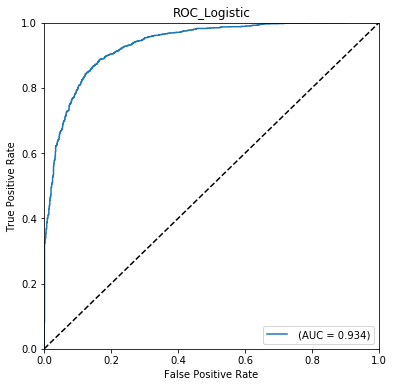

In [358]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [359]:
# trigram
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [370]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.866120218579


0.932546260258


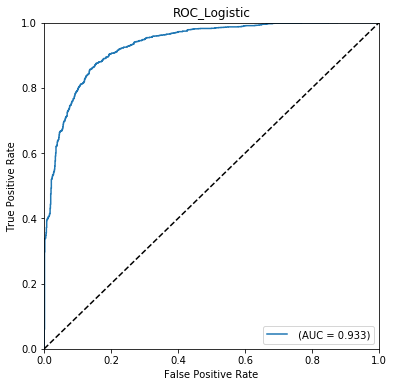

In [371]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [323]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.857923497268


0.929933320669


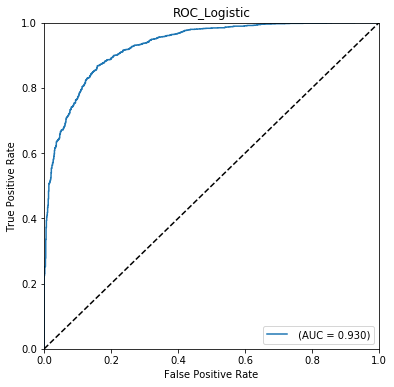

In [324]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [325]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [326]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.859631147541


0.928818823992


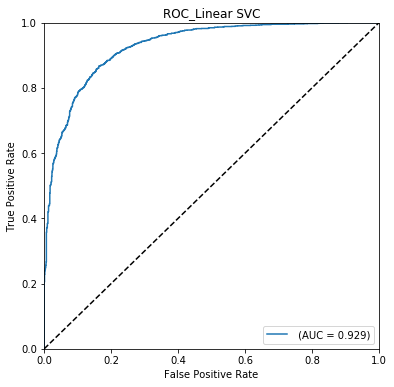

In [327]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [328]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.859289617486


0.929496995345


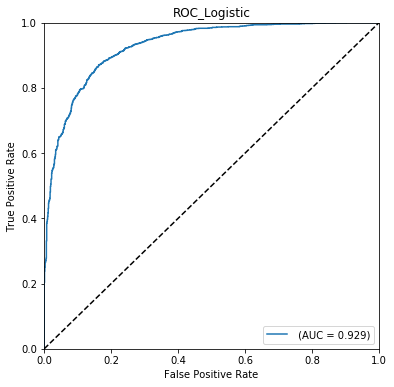

In [329]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [330]:
clf_sgd=linear_model.SGDClassifier(loss='log', penalty='l2', \
                                   alpha=1e-4, n_iter=100, \
                                   fit_intercept=False, random_state=42)
clf_sgd.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_sgd.predict(tX_valid))
print(accuracy)

0.854849726776


0.927912089344


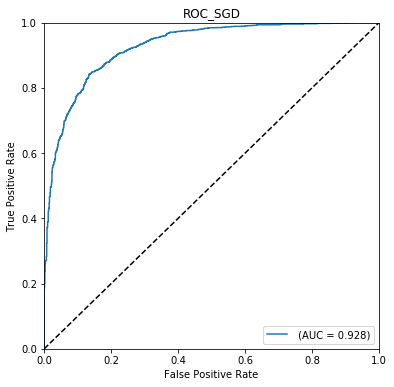

In [331]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_sgd, 'SGD')

In [94]:
# train on balanced data and validatio on imbalanced data
X_train, X_valid, y_train, y_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)
dtr=pd.DataFrame()
dtr['text'] = X_train
dtr['label'] = y_train
df0 = dtr[dtr['label']==0].sample(n=len(y_train[y_train==2]))
df1 = dtr[dtr['label']==1].sample(n=len(y_train[y_train==2]))
df2 = dtr[dtr['label']==2]
df_train = df0.append(df1).append(df2)
X_train = df_train['text']
y_train = df_train['label']
df_valid = pd.DataFrame()
df_valid['text'] = X_valid
df_valid['label'] = y_valid
df = df_train.append(df_valid)

In [95]:
# unigrams
count_vect = CountVectorizer()
count_vect.fit(df['text'])
X_tr = count_vect.transform(X_train)
X_val = count_vect.transform(X_valid)

In [96]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_tr, y_train)
clf_ovr.predict(X_tr)

accuracy = np.mean(y_valid == clf_ovr.predict(X_val))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_val))

0.741120218579


array([[1413,  347,  129],
       [  88,  410,   82],
       [  41,   71,  347]])

0.889190388714


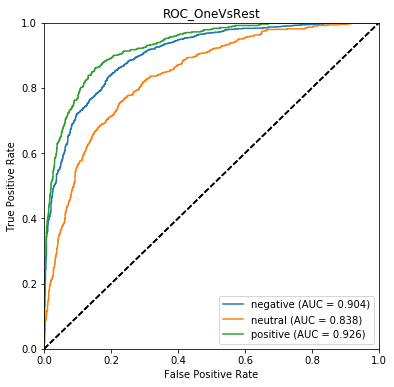

In [97]:
plotRocCurve(X_tr, y_train, X_val, y_valid, clf_ovr, 'OneVsRest')